### Word2Vec using SVD

In [1]:
#importing required Modules
%matplotlib inline
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

In [2]:
#getting cleaned data from db
conn = sqlite3.connect('final_clean_dt1.sqlite')
final_review = pd.read_sql_query("""
SELECT *
FROM Reviews_final
""", conn) 

In [3]:
#SORT by time for TBS
final_review = final_review.sort_values(by='Time')

In [4]:
#Converting to int8
final_review.HelpfulnessNumerator = final_review.\
                      HelpfulnessNumerator.astype(np.int8)
final_review.HelpfulnessDenominator = final_review.\
                      HelpfulnessDenominator.astype(np.int8)

In [5]:
final_review.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 364171 entries, 23 to 345187
Data columns (total 6 columns):
index                     364171 non-null int64
HelpfulnessNumerator      364171 non-null int8
HelpfulnessDenominator    364171 non-null int8
Score                     364171 non-null object
final_text                364171 non-null object
Time                      364171 non-null int64
dtypes: int64(2), int8(2), object(2)
memory usage: 14.6+ MB


In [6]:
#TFIDF with (1,2) gram with cleaned data 
#tfidf vec 
tf_idf_vect = TfidfVectorizer(ngram_range=(1,1))
final_counts_train = tf_idf_vect.fit_transform(
        final_review['final_text'].values)

In [7]:
#transpose
tfidf_transp = final_counts_train.T
tfidf_transp

<67227x364171 sparse matrix of type '<class 'numpy.float64'>'
	with 16826215 stored elements in Compressed Sparse Column format>

In [10]:
features = tf_idf_vect.get_feature_names()
len(features)

67227

In [40]:
#for each word getting max tfidf
feature_max = {}
for i in range(tfidf_transp.get_shape()[0]):
    feature_max[features[i]] = tfidf_transp[i].max()

In [12]:
#sorting
import operator
sorted_feature = dict(sorted(feature_max.items(), key=operator.itemgetter(1),reverse=True))

In [13]:
#top 2000 words
top_tfidf = list(sorted_feature.keys())[0:2000]

In [9]:
def cooccurrence_matrix(list_words,distance,sentances):
    '''
    Returns co-occurrence matrix of words with in a distance of occurrrence
    input:
        list_words: list of words to get the co-occurrance matrix in order
        distance: distance between words
        sentances: documets to check ( a list )
    output:
        co-occurance matrix in te order of list_words order
    '''
    #length of matrix needed
    l = len(list_words)
    #creating a zero matrix 
    com = np.zeros((l,l))
    #creating word and index dict
    dict_idx = {v:i for i,v in enumerate(list_words)}
    for sentence in sentances:
        sentence=sentence.strip()
        tokens= sentence.split()
        for pos,token in enumerate(tokens):
            #if  eord is in required words
            if token in list_words:
                #start index to check any other word occure or not
                start=max(0,pos-distance)
                #end index
                end=min(len(tokens),pos+distance+1)
                for pos2 in range(start,end):
                    #if same position 
                    if pos2==pos: 
                        continue
                    # if same word
                    if token == tokens[pos2]:
                        continue
                    #if word found is in required words
                    if tokens[pos2] in list_words:
                        #index of word parent
                        row = dict_idx[token]
                        #index of occurance word
                        col = dict_idx[tokens[pos2]]
                        #adding value to that index
                        com[row,col] = com[row,col] + 1
    return com

##### With top 2000 words

In [13]:
#co-occurrance matrix for top 2000 words
docs = list(final_review.final_text.values)
out_com = cooccurrence_matrix(top_tfidf,5,docs)

In [19]:
out_com

array([[  0., 420.,   8., ...,   0.,   0.,  63.],
       [420.,   0.,   0., ...,   0.,   0.,   2.],
       [  8.,   0.,   0., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [ 63.,   2.,   0., ...,   0.,   0.,   0.]])

In [20]:
out_com.shape

(2000, 2000)

In [21]:
#svd
svd = TruncatedSVD(n_components=300, n_iter=7, random_state=42)
svd.fit(out_com)

TruncatedSVD(algorithm='randomized', n_components=300, n_iter=7,
       random_state=42, tol=0.0)

Text(0.5,1,'plot for cumulative variace')

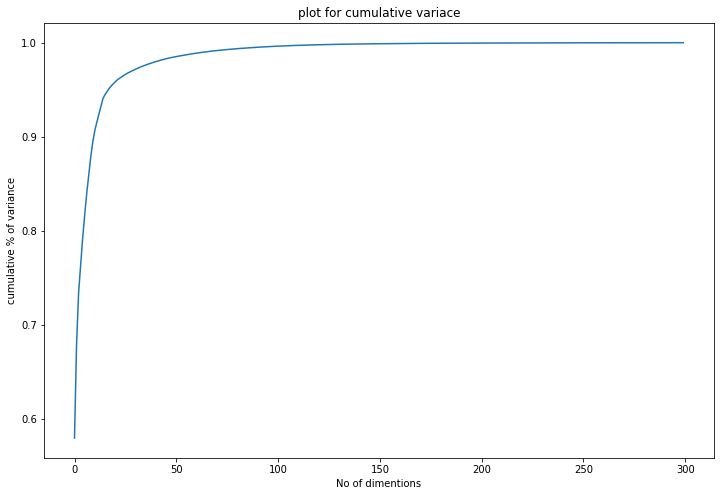

In [22]:
%matplotlib inline
plt.figure(figsize=(12,8))
plt.plot(range(300),np.cumsum(svd.explained_variance_ratio_))
plt.xlabel('No of dimentions')
plt.ylabel('cumulative % of variance')
plt.title('plot for cumulative variace')

for 100 dimensions it is giving upto 99.6% of data so 100 may be better dimensions

In [23]:
#truncated svd wit 100 dimensions
svd = TruncatedSVD(n_components=100, n_iter=7, random_state=42)
svd.fit(out_com)

TruncatedSVD(algorithm='randomized', n_components=100, n_iter=7,
       random_state=42, tol=0.0)

In [24]:
#tranforming co-occurrance matrix
vectors_2000 = svd.transform(out_com)

In [153]:
#dic of word vectors
W2V = {}
j = 0
for i in top_tfidf:
    W2V[i] = vectors_2000[j]
    j = j + 1

In [26]:
#k-means clustering
from sklearn.cluster import KMeans
ssd = {}
centers = {}
for k in range(1,31):
    model = KMeans(n_clusters=k,n_init=10,max_iter=800,random_state=25,n_jobs=-1)
    model.fit(vectors_2000)
    ssd[k] = model.inertia_
    centers[k] = model.cluster_centers_
    print('No of clusters',k,'Sum of Squared dist',model.inertia_)

No of clusters 1 Sum of Squared dist 4877602214.132303
No of clusters 2 Sum of Squared dist 2848327811.6363153
No of clusters 3 Sum of Squared dist 2368310131.8099008
No of clusters 4 Sum of Squared dist 1888438052.9530783
No of clusters 5 Sum of Squared dist 1709023215.7052429
No of clusters 6 Sum of Squared dist 1520932072.2748759
No of clusters 7 Sum of Squared dist 1398191685.867318
No of clusters 8 Sum of Squared dist 1255703462.999013
No of clusters 9 Sum of Squared dist 1162091623.086074
No of clusters 10 Sum of Squared dist 1070733163.8514141
No of clusters 11 Sum of Squared dist 963739990.1647408
No of clusters 12 Sum of Squared dist 889243208.9334568
No of clusters 13 Sum of Squared dist 832131817.1269792
No of clusters 14 Sum of Squared dist 773070086.6334343
No of clusters 15 Sum of Squared dist 719084672.1616017
No of clusters 16 Sum of Squared dist 648636464.059645
No of clusters 17 Sum of Squared dist 603817090.2464777
No of clusters 18 Sum of Squared dist 593100950.0212

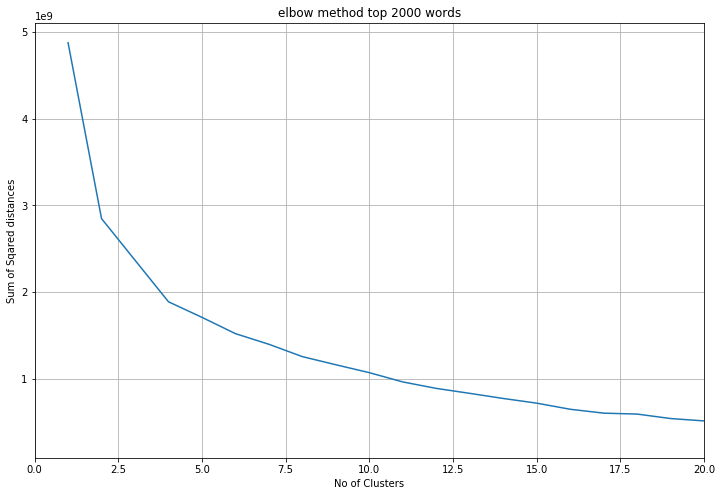

In [27]:
plt.figure(figsize=(12,8))
plt.plot(list(ssd.keys()),list(ssd.values()))
plt.xlim(0,20)
plt.xlabel('No of Clusters')
plt.ylabel('Sum of Sqared distances')
plt.title('elbow method top 2000 words')
plt.grid()

after 4 clusters decrease is low so 4 may be good choice

In [122]:
model4 = KMeans(n_clusters=4,n_init=10,max_iter=800,random_state=25,n_jobs=-1)
model4.fit(vectors_2000)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=800,
    n_clusters=4, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=25, tol=0.0001, verbose=0)

In [123]:
labels = model4.labels_
labels

array([2, 0, 0, ..., 0, 0, 0])

In [124]:
final_data_2000 = pd.DataFrame(np.hstack((np.array(top_tfidf).reshape(-1,1),
                             vectors_2000,labels.reshape(-1,1))))

In [125]:
grp = final_data_2000.groupby(101)[0]

In [126]:
grp.count()

101
0    1959
1       3
2       3
3      35
Name: 0, dtype: int64

In [127]:
grp.get_group('0')

1               yum
2                aa
3              word
5            banana
6              bole
7                mm
8            filler
10              nom
11             spam
12             salt
13             vous
14            stale
15            ranch
16            booty
17       crackheads
18              sen
19             lard
20         horchata
21             wham
23          mustard
24          awesome
25        capachino
26         horlicks
27             lock
28             chow
29            milka
30         cocoquik
31              tsk
32          praline
33         licorage
           ...     
1968      bellyache
1969         popeye
1970          alapa
1971       collagen
1972       sriracha
1973          anvil
1974        rainbow
1975    crackerjack
1976        warhead
1977        tiparos
1978           date
1979        soyajoy
1980        opinion
1981      distiller
1982        brining
1983         sambar
1984     remembered
1985        baxters
1986         skinny


In [128]:
grp.get_group('1')

9      really
632       tea
815    coffee
Name: 0, dtype: object

In [129]:
grp.get_group('2')

0        good
4        love
1280    great
Name: 0, dtype: object

In [130]:
grp.get_group('3')

22      delicious
54            hot
124         yummy
198       organic
260          rice
490           cat
502          deal
582         drink
624          milk
760       coconut
809         tasty
832     chocolate
886          bean
919          soup
931          chip
949           dog
961          real
1006          bar
1139         work
1151          bag
1174        cooky
1190        candy
1255         much
1266          oil
1330       cereal
1360      vanilla
1468         free
1469        sauce
1539         dark
1629        roast
1752      variety
1822       peanut
1907        water
1989          low
1995        fruit
Name: 0, dtype: object

We can obsever some similar words in clusters, like  
0 - some miscellaneous fetures of products  
1 - giving teal coffe really, tea coffe are similar products  
2 - giving good love great,  these are also similar words  
3 - these are some words to decribe about produts.  

In [10]:
def top_similar_words(v,Wordvectors,n,list_words):
    """
    Gives output angles between one vector(v1) and all other vectors as matrix(v2)
    input:
        v  shape (d,1)
        Wordvectors shape (m,d)
        n - no of similarities needed
        list_words - list of all words in Wordvectors in same order
    output:
        list of n words which are similar
    """
    v1 = np.array(v)
    v1 = v1.reshape(-1,1)
    v2 = np.array(Wordvectors)
    #dot product
    nr = np.dot(v2,v1)
    #vector lengths 2-norm
    dr = (np.linalg.norm(v1)*np.linalg.norm(v2,axis=1)).reshape(-1,1)
    # angle i.e cosine inverse and domine for cosine inverse is 
    # [-1,1] so clipping to [-1,1] and claculating angle
    ang = np.arccos(np.clip(nr/dr,-1,1))
    ang = ang.ravel()
    #sorting and getting index of top n 
    ang_10 = np.argsort(ang)[0:n+1]
    ang_n = np.delete(ang_10,0)
    dict_tfidf = {i:v for i,v in enumerate(list_words)}
    return [dict_tfidf[i] for i in ang_n]

In [160]:
top_similar_words(W2V['good'],vectors_2000,10,top_tfidf)

['horrible',
 'outstanding',
 'terrible',
 'fantastic',
 'fabulous',
 'delicious',
 'incredible',
 'horrid',
 'much',
 'blah']

In [161]:
top_similar_words(W2V['yum'],vectors_2000,10,top_tfidf)

['yummy',
 'delish',
 'awesome',
 'father',
 'god',
 'wow',
 'sucker',
 'tasty',
 'much',
 'addicting']

In [164]:
top_similar_words(W2V['mm'],vectors_2000,10,top_tfidf)

['umm',
 'hmm',
 'really',
 'remembered',
 'amazingly',
 'saucisson',
 'halva',
 'bye',
 'jammer',
 'kolaches']

In [166]:
for i in top_tfidf:
    print('Similar words for',i)
    print(top_similar_words(W2V[i],vectors_2000,10,top_tfidf))

Similar words for good
['horrible', 'outstanding', 'terrible', 'fantastic', 'fabulous', 'delicious', 'incredible', 'horrid', 'much', 'blah']
Similar words for yum
['yummy', 'delish', 'awesome', 'father', 'god', 'wow', 'sucker', 'tasty', 'much', 'addicting']
Similar words for aa
['overprice', 'winegums', 'umm', 'jammer', 'kolaches', 'antigen', 'costellinis', 'cankersores', 'licorage', 'natrataste']
Similar words for word
['agree', 'worth', 'question', 'opinion', 'satisfied', 'tasty', 'flavour', 'wow', 'lie', 'variety']
Similar words for love
['poor', 'lui', 'medicine', 'terrible', 'happy', 'ideal', 'sensitive', 'obsessed', 'horrible', 'act']
Similar words for banana
['muffin', 'mumm', 'crumb', 'yeast', 'rise', 'sourdough', 'bagel', 'caraway', 'loaf', 'peanut']
Similar words for bole
['dreamfields', 'orecchiette', 'penne', 'fusilli', 'orzo', 'pierogies', 'cavatappi', 'ink', 'rice', 'quinoa']
Similar words for mm
['umm', 'hmm', 'really', 'remembered', 'amazingly', 'saucisson', 'halva', 'b

['terrible', 'horrible', 'worth', 'bland', 'question', 'outstanding', 'grateful', 'word', 'variety', 'opinion']
Similar words for togarashi
['saladitos', 'droewors', 'amie', 'heezies', 'pooching', 'grandchild', 'marmite', 'booty', 'macaw', 'nonstarch']
Similar words for ghee
['polenta', 'lollipop', 'flaxseed', 'tahini', 'vegan', 'chia', 'sucker', 'cereal', 'sprouting', 'item']
Similar words for raclette
['havarti', 'kellygold', 'locatelli', 'macaroni', 'mascarpone', 'cheddar', 'velveeta', 'dubliner', 'limburger', 'whiz']
Similar words for escargot
['item', 'gnocchi', 'college', 'peppercorn', 'gyro', 'grandparent', 'snail', 'nepenthes', 'melba', 'thanks']
Similar words for shortbread
['biscoff', 'amaretti', 'fluor', 'doozies', 'goldenfruit', 'danish', 'oreo', 'scrabble', 'nutter', 'pannetone']
Similar words for bearcreek
['dumpling', 'broth', 'kiev', 'minestrone', 'baxters', 'miso', 'gumbo', 'bouillon', 'pork', 'noodle']
Similar words for vere
['oreos', 'mulberry', 'catmilk', 'antler', 

['photo', 'tiny', 'smashed', 'listing', 'bug', 'date', 'target', 'freshness', 'rip', 'giant']
Similar words for grade
['formaldehyde', 'cough', 'maple', 'karo', 'torans', 'alapa', 'vinci', 'agave', 'talitol', 'noway']
Similar words for dummy
['sucker', 'starbursts', 'lollipop', 'yum', 'yummy', 'allsorts', 'centipede', 'licorice', 'father', 'addicting']
Similar words for fastgreat
['fastgreat', 'humidor', 'adenium', 'crabcakes', 'churro', 'ballistics', 'chompchompchomp', 'transaction', 'vincafe', 'kuchela']
Similar words for clove
['cardamom', 'nutmeg', 'cardamon', 'anise', 'cert', 'turmeric', 'peel', 'fennel', 'wintergreen', 'cumin']
Similar words for tuna
['mayo', 'fish', 'tunafish', 'salmon', 'sardine', 'mayonnaise', 'crabmeat', 'rub', 'lobster', 'herring']
Similar words for washed
['scalp', 'sheen', 'conditioner', 'comb', 'shampoo', 'blow', 'rosewater', 'brush', 'feather', 'scent']
Similar words for caraway
['sourdough', 'loaf', 'pinko', 'rise', 'rye', 'crumb', 'cornichons', 'yeast'

['kale', 'plantain', 'popchips', 'tortilla', 'pita', 'friths', 'seneca', 'choc', 'fanfreakintastic', 'bugle']
Similar words for taro
['work', 'game', 'dent', 'thanks', 'item', 'orchid', 'poor', 'indigestion', 'plant', 'fun']
Similar words for rehab
['indigestion', 'bed', 'party', 'ideal', 'smoothly', 'replacement', 'selection', 'sleep', 'office', 'roach']
Similar words for hedgehog
['licking', 'skunk', 'mackerel', 'bid', 'thyroid', 'pate', 'barf', 'halo', 'catnip', 'approved']
Similar words for mayonnaise
['mayo', 'ketchup', 'pasta', 'dill', 'radish', 'kewpie', 'cheese', 'pickle', 'taco', 'sardine']
Similar words for hmm
['mm', 'really', 'umm', 'book', 'remembered', 'heart', 'win', 'word', 'opinion', 'question']
Similar words for divinity
['flamingo', 'latte', 'masala', 'chama', 'rio', 'anise', 'fragrant', 'anger', 'magically', 'peppermint']
Similar words for bend
['act', 'biscuit', 'ear', 'medicine', 'poor', 'tail', 'fart', 'lui', 'love', 'dick']
Similar words for goldfish
['saltine',

['promised', 'described', 'quantity', 'worth', 'satisfied', 'book', 'really', 'hmm', 'overpriced', 'batch']
Similar words for persimmon
['deglut', 'shiitake', 'morel', 'sancho', 'porcini', 'apricot', 'cheerier', 'cantaloupe', 'glandules', 'mango']
Similar words for grander
['snowflake', 'sachet', 'omgosh', 'chi', 'hay', 'shorted', 'tee', 'einstein', 'satchel', 'energize']
Similar words for soyrizo
['triplet', 'grandson', 'grandkids', 'sweetfiber', 'jake', 'grandchild', 'dog', 'pooching', 'fondarific', 'poptarts']
Similar words for lentil
['pea', 'minestrone', 'miso', 'dashi', 'mushroom', 'chowder', 'noodle', 'asparagus', 'pho', 'squash']
Similar words for cherri
['oreos', 'mulberry', 'catmilk', 'antler', 'freshness', 'tigger', 'repel', 'decaffeinated', 'party', 'cesar']
Similar words for fontal
['oreos', 'mulberry', 'catmilk', 'antler', 'freshness', 'tigger', 'repel', 'decaffeinated', 'party', 'cesar']
Similar words for sauerkraut
['kraut', 'brat', 'relish', 'pickle', 'bun', 'spicy', '

['flavour', 'stevia', 'organic', 'tasty', 'cinnamon', 'demerara', 'sweeter', 'word', 'delicious', 'licorice']
Similar words for devise
['poor', 'act', 'lui', 'love', 'sensitive', 'indigestion', 'agree', 'terrible', 'ajar', 'hedgehog']
Similar words for bow
['resist', 'pic', 'forever', 'dent', 'agree', 'worth', 'thankyou', 'really', 'happy', 'win']
Similar words for breadcrumb
['rub', 'stuffing', 'soup', 'burger', 'mesquite', 'shrimp', 'asparagus', 'nugget', 'sausage', 'fish']
Similar words for transaction
['vincafe', 'kuchela', 'deal', 'dorm', 'adenium', 'item', 'humidor', 'fastgreat', 'mimicreme', 'thanks']
Similar words for filter
['keurig', 'master', 'weak', 'decaff', 'kona', 'chicory', 'caribou', 'monde', 'clock', 'dallmayr']
Similar words for peppermint
['mint', 'ireland', 'minty', 'yerba', 'british', 'exquisite', 'match', 'ginseng', 'chai', 'title']
Similar words for zone
['heath', 'mar', 'clark', 'snicker', 'granola', 'powerbar', 'payday', 'fiberone', 'musketeer', 'glucerna']
Si

['sprout', 'soup', 'okra', 'squash', 'blackeye', 'dal', 'asparagus', 'pea', 'stage', 'tofu']
Similar words for weaver
['ethiopian', 'kona', 'master', 'chicory', 'clock', 'cuban', 'caribou', 'colombian', 'dallmayr', 'millstone']
Similar words for lipton
['oreos', 'mulberry', 'catmilk', 'antler', 'freshness', 'tigger', 'repel', 'decaffeinated', 'party', 'cesar']
Similar words for moringa
['zinger', 'hojicha', 'detox', 'eh', 'chamomile', 'rosehip', 'stash', 'british', 'kombucha', 'rooibos']
Similar words for hummus
['salami', 'dip', 'breadstick', 'guacamole', 'ham', 'chorizo', 'topping', 'hotdog', 'tahini', 'spam']
Similar words for izzy
['oreos', 'mulberry', 'catmilk', 'antler', 'freshness', 'tigger', 'repel', 'decaffeinated', 'party', 'cesar']
Similar words for yorkie
['yorkies', 'schnauzer', 'pug', 'pitbull', 'chihuahua', 'puppy', 'doggy', 'bulldog', 'tillman', 'gizmo']
Similar words for milk
['marshmallow', 'liquor', 'kiss', 'incredible', 'sorbet', 'malt', 'marzipan', 'melted', 'mumm'

['pest', 'moth', 'gopher', 'fly', 'glove', 'lunch', 'mole', 'bug', 'mosquito', 'repel']
Similar words for winterfrost
['wintergreen', 'bazooka', 'spearmint', 'gumballs', 'empowerment', 'gum', 'xylichew', 'mentos', 'trident', 'dentine']
Similar words for marrowbone
['lammy', 'dreambones', 'antler', 'hoof', 'chewie', 'baneful', 'cesar', 'petrodex', 'bone', 'flossies']
Similar words for bambino
['cornzapoppin', 'movie', 'hull', 'amish', 'poppycock', 'theatre', 'tm', 'pop', 'husk', 'flavorcol']
Similar words for shorted
['rip', 'lock', 'giant', 'pound', 'freshness', 'bug', 'biobag', 'asin', 'leak', 'per']
Similar words for chat
['dressing', 'crouton', 'worst', 'weak', 'decaf', 'decaffeinated', 'mate', 'filter', 'decaff', 'kenyan']
Similar words for umeboshi
['appletini', 'bacony', 'yahoo', 'cider', 'angostura', 'moxie', 'wine', 'neuro', 'soda', 'gross']
Similar words for teeccino
['keurig', 'kahlua', 'master', 'chicory', 'caribou', 'millstone', 'bold', 'monde', 'cuban', 'kona']
Similar wor

['caraway', 'twiglet', 'sourdough', 'chere', 'beigel', 'loaf', 'rye', 'yeast', 'escargot', 'breadstick']
Similar words for kabosu
['mimicreme', 'fastgreat', 'humidor', 'sangria', 'college', 'adenium', 'crabcakes', 'fondarific', 'transaction', 'churro']
Similar words for mayo
['mayonnaise', 'slaw', 'tuna', 'dill', 'crabmeat', 'pickle', 'radish', 'cucumber', 'pasta', 'burger']
Similar words for satay
['enchilada', 'barbecue', 'nandow', 'tempura', 'shab', 'bearnaise', 'popeyes', 'yoshidas', 'spaghetti', 'taco']
Similar words for tasty
['wow', 'agree', 'funky', 'yummy', 'satisfied', 'word', 'worth', 'delicious', 'question', 'flavour']
Similar words for lambrusco
['oreos', 'mulberry', 'catmilk', 'antler', 'freshness', 'tigger', 'repel', 'decaffeinated', 'party', 'cesar']
Similar words for goaty
['ficus', 'replacer', 'banzai', 'dairy', 'nog', 'asthma', 'wowbutter', 'dye', 'squirrel', 'egg']
Similar words for korean
['kimchi', 'ramen', 'ramyun', 'udon', 'shin', 'lasagna', 'yakisoba', 'tofu', 

['peach', 'dragon', 'peachy', 'fruity', 'rose', 'flower', 'boba', 'blackcurrant', 'currant', 'ireland']
Similar words for swedish
['rind', 'seabeard', 'waffle', 'chicken', 'muffin', 'scone', 'crepe', 'fillet', 'cornbread', 'grouper']
Similar words for masa
['bleached', 'sorghum', 'spelt', 'teff', 'tapioca', 'chickpea', 'arrowroot', 'cornmeal', 'chestnut', 'millet']
Similar words for calcium
['iron', 'fibre', 'plenish', 'vitamin', 'omega', 'hemp', 'paltry', 'cholesterol', 'probiotic', 'protein']
Similar words for smoothly
['described', 'office', 'promised', 'agree', 'variety', 'selection', 'wow', 'indigestion', 'overpriced', 'outstanding']
Similar words for longo
['oreos', 'mulberry', 'catmilk', 'antler', 'freshness', 'tigger', 'repel', 'decaffeinated', 'party', 'cesar']
Similar words for mosquito
['gopher', 'install', 'pest', 'fly', 'bulb', 'sharkbanana', 'roach', 'cakepops', 'lunch', 'dishwasher']
Similar words for inhaler
['pickling', 'herbamare', 'pink', 'tartaric', 'lamp', 'flavorc

['pilon', 'kona', 'caribou', 'cuban', 'bold', 'millstone', 'keurig', 'timothy', 'monde', 'tchibo']
Similar words for mirabelle
['dolmas', 'ackee', 'cornnuts', 'cava', 'saucisson', 'haggis', 'popeye', 'overcharge', 'scrapple', 'umm']
Similar words for max
['solved', 'happy', 'obsessed', 'forever', 'god', 'much', 'brother', 'grateful', 'win', 'worth']
Similar words for fake
['yuck', 'lie', 'word', 'flavour', 'question', 'disgusting', 'real', 'tasty', 'icky', 'gross']
Similar words for japanese
['cha', 'genmaicha', 'jasmine', 'british', 'tip', 'chang', 'kukicha', 'stash', 'teavana', 'oolong']
Similar words for formula
['stage', 'happy', 'mum', 'probiotic', 'rabbit', 'approved', 'sensitive', 'fern', 'poo', 'filler']
Similar words for dal
['sprout', 'okra', 'asparagus', 'dented', 'sprouting', 'couscous', 'pea', 'chorizo', 'grit', 'nori']
Similar words for genito
['powerbar', 'zone', 'granola', 'snicker', 'heath', 'mound', 'mar', 'glucerna', 'halvah', 'kat']
Similar words for sharkbanana
['m

['assam', 'lifeboat', 'novus', 'zat', 'darjeeling', 'oolong', 'herbal', 'rishi', 'marketspice', 'adagio']
Similar words for stain
['medicine', 'dirt', 'color', 'poor', 'bed', 'happy', 'grateful', 'forever', 'solved', 'love']
Similar words for msc
['oreos', 'mulberry', 'catmilk', 'antler', 'freshness', 'tigger', 'repel', 'decaffeinated', 'party', 'cesar']
Similar words for waffies
['cheddar', 'macaroni', 'havarti', 'velveeta', 'raclette', 'whiz', 'mascarpone', 'limburger', 'kellygold', 'locatelli']
Similar words for caramilk
['chimp', 'kat', 'granola', 'milky', 'mound', 'snicker', 'halvah', 'powerbar', 'mar', 'lint']
Similar words for chowder
['bisque', 'asparagus', 'noodle', 'chunky', 'lentil', 'dashi', 'minestrone', 'gumbo', 'pea', 'pho']
Similar words for kuchela
['vincafe', 'transaction', 'nepman', 'deal', 'chaplet', 'mimicreme', 'fastgreat', 'humidor', 'adenium', 'starter']
Similar words for cakepops
['carabiner', 'gopher', 'install', 'probe', 'mole', 'ballistics', 'mosquito', 'dre

['ritz', 'vinta', 'saltine', 'otc', 'goldfish', 'keeler', 'kame', 'smore', 'crispbread', 'glutinose']
Similar words for flower
['rose', 'eh', 'boba', 'detox', 'match', 'pearl', 'tip', 'yerba', 'stash', 'hojicha']
Similar words for caff
['decaff', 'keurig', 'bold', 'expresso', 'teeccino', 'hawaii', 'timothy', 'sidamo', 'kenya', 'tiger']
Similar words for angelica
['bug', 'nori', 'kojis', 'tea', 'date', 'glove', 'popchip', 'oatmeal', 'grit', 'smashed']
Similar words for hempseeds
['tabouli', 'sprouting', 'vegan', 'lollipop', 'tahini', 'party', 'churro', 'ghee', 'item', 'adenium']
Similar words for specimen
['deal', 'plant', 'transaction', 'vincafe', 'nepman', 'item', 'kuchela', 'thanks', 'baklava', 'backpacking']
Similar words for odour
['vita', 'vitacoco', 'zinco', 'thailand', 'prowl', 'kasha', 'flake', 'hedgehog', 'crow', 'hmm']
Similar words for fruity
['peachy', 'title', 'match', 'minty', 'boba', 'peppermint', 'ireland', 'flower', 'kombucha', 'yerba']
Similar words for etouffee
['gyr

['opinion', 'title', 'worth', 'satisfied', 'terrible', 'flavour', 'bland', 'funky', 'question', 'word']
Similar words for clorets
['oreos', 'mulberry', 'catmilk', 'antler', 'freshness', 'tigger', 'repel', 'decaffeinated', 'party', 'cesar']
Similar words for brio
['klutzy', 'moccona', 'dallmayr', 'hawaiiroasters', 'cafestol', 'monde', 'chicory', 'master', 'tchibo', 'kona']
Similar words for tiger
['bold', 'timothy', 'cuban', 'caribou', 'keurig', 'gevalia', 'expresso', 'colombian', 'kona', 'millstone']
Similar words for hawaii
['expresso', 'keurig', 'tim', 'teeccino', 'decaff', 'bold', 'kahlua', 'maui', 'master', 'tiger']
Similar words for andouille
['hen', 'broth', 'biryani', 'pork', 'gumbo', 'nugget', 'bouillon', 'dumpling', 'shrimp', 'beef']
Similar words for cornmeal
['buffalo', 'teff', 'spelt', 'headphone', 'seitan', 'free', 'rice', 'masa', 'crepe', 'rye']
Similar words for necklace
['ardor', 'sweetarts', 'pepsin', 'peerless', 'brachs', 'airhead', 'smarties', 'spree', 'cherryheads',

['scratcher', 'hairball', 'catnip', 'kookamunga', 'nip', 'siamese', 'kitty', 'feline', 'pate', 'litter']
Similar words for marinara
['bearnaise', 'yoshida', 'barbecue', 'shab', 'enchilada', 'chipotle', 'yoshidas', 'newburg', 'spaghetti', 'horsey']
Similar words for pancake
['cornbread', 'scone', 'muffin', 'crepe', 'mascarons', 'grandparent', 'bread', 'flan', 'wow', 'item']
Similar words for jaybars
['jammer', 'cankersores', 'costellinis', 'licorage', 'antigen', 'kolaches', 'natrataste', 'salsifis', 'umm', 'overprice']
Similar words for stabilizer
['mastic', 'xylitol', 'bubble', 'stride', 'trident', 'orbit', 'dentine', 'xylichew', 'whitening', 'yapp']
Similar words for nepenthes
['gyro', 'escargot', 'gnocchi', 'haggis', 'ketchup', 'ackee', 'pasta', 'dale', 'peppercorn', 'melba']
Similar words for cleansing
['detox', 'pm', 'eh', 'kombucha', 'boba', 'flower', 'british', 'chest', 'tip', 'dragonwell']
Similar words for soda
['coke', 'cola', 'fizzy', 'appletini', 'fizzier', 'celsius', 'golaz

['nito', 'horlicks', 'capachino', 'soy', 'dud', 'fenugreek', 'quark', 'nesquick', 'almond', 'soyajoy']
Similar words for gel
['plant', 'item', 'fun', 'agar', 'coloring', 'cap', 'thanks', 'wow', 'color', 'sharpy']
Similar words for rosehip
['chamomile', 'rooibos', 'tulsi', 'stash', 'herbal', 'assam', 'pickwick', 'teavana', 'petal', 'rishi']
Similar words for magnolia
['assam', 'rishi', 'perh', 'darjeeling', 'tulsi', 'osmanthus', 'oolong', 'yunnan', 'chamomile', 'rooibos']
Similar words for blow
['lid', 'cap', 'rock', 'run', 'dirt', 'pourer', 'horrid', 'equal', 'gal', 'quit']
Similar words for peaberry
['kona', 'colombian', 'ethiopian', 'caribou', 'cuban', 'millstone', 'bold', 'monde', 'master', 'pilon']
Similar words for reuse
['disposable', 'freshness', 'title', 'tee', 'leak', 'office', 'drink', 'rip', 'awake', 'gold']
Similar words for samoan
['nom', 'poptarts', 'baklawa', 'addicting', 'sucker', 'yum', 'cheesecorn', 'yummy', 'lollipop', 'grandkids']
Similar words for acana
['kibble', 

['artemis', 'diarrhea', 'oleo', 'baneful', 'seizure', 'fart', 'mya', 'ear', 'petrodex', 'tow']
Similar words for listing
['photo', 'count', 'freshness', 'cardboard', 'quantity', 'target', 'ripoff', 'rip', 'forever', 'tiny']
Similar words for liter
['tonic', 'smartwater', 'fiji', 'blk', 'propel', 'penta', 'distiller', 'sewer', 'esbilac', 'perrier']
Similar words for dreamwater
['spammer', 'catchmaster', 'mandoline', 'repel', 'agora', 'carabiner', 'cakepops', 'probe', 'moth', 'transmitter']
Similar words for fern
['mum', 'toddler', 'stage', 'twin', 'formula', 'grandparent', 'fondarific', 'grandson', 'college', 'soyrizo']
Similar words for liq
['crunchamame', 'justcaviar', 'benison', 'cannoli', 'jaybars', 'ballad', 'stringy', 'emmet', 'ono', 'tawny']
Similar words for mimicreme
['fastgreat', 'humidor', 'adenium', 'crabcakes', 'churro', 'ballistics', 'chompchompchomp', 'transaction', 'vincafe', 'kuchela']
Similar words for milo
['venison', 'duke', 'avoderm', 'bone', 'salmon', 'nugget', 'ch

['dye', 'dairy', 'scd', 'flour', 'email', 'millet', 'filler', 'jello', 'buckwheat', 'vegan']
Similar words for ganocafe
['hawaii', 'filter', 'vinacafe', 'watery', 'nabob', 'creamer', 'pilon', 'decaff', 'keurig', 'dandyblend']
Similar words for fixed
['run', 'worth', 'poor', 'horrible', 'terrible', 'satisfied', 'horrid', 'question', 'ideal', 'tiny']
Similar words for imperial
['tulsi', 'hojicha', 'rishi', 'rooibos', 'assam', 'herbal', 'chamomile', 'adagio', 'eh', 'yunnan']
Similar words for nigori
['evermore', 'curcumin', 'fizzier', 'activate', 'vitamin', 'smartwater', 'fizzy', 'tonic', 'celsius', 'propel']
Similar words for trifle
['custard', 'addicting', 'flan', 'cupcake', 'nutritious', 'meringue', 'treacle', 'festive', 'num', 'handout']
Similar words for clock
['kona', 'caribou', 'master', 'dallmayr', 'millstone', 'cuban', 'colombian', 'monde', 'keurig', 'tchibo']
Similar words for toy
['checkup', 'antler', 'bone', 'ear', 'duke', 'greenies', 'hoof', 'petrodex', 'woof', 'cesar']
Simil

['dreambones', 'lambies', 'lammy', 'chewie', 'flossies', 'chihuahua', 'woof', 'dingo', 'marrowbone', 'antler']
Similar words for larabars
['candy', 'sen', 'twin', 'grandson', 'daughter', 'grandkids', 'poptarts', 'grandchild', 'yummy', 'granddaughter']
Similar words for calmato
['clementine', 'grape', 'grapefruit', 'mangosteen', 'wheatgrass', 'lime', 'tequila', 'beet', 'prune', 'lemon']
Similar words for kolaches
['antigen', 'cankersores', 'licorage', 'costellinis', 'jammer', 'natrataste', 'overprice', 'saucisson', 'umm', 'winegums']
Similar words for gyokuro
['oolong', 'herbal', 'darjeeling', 'adagio', 'teavana', 'marketspice', 'salada', 'lyon', 'lifeboat', 'blooming']
Similar words for brm
['oreos', 'mulberry', 'catmilk', 'antler', 'freshness', 'tigger', 'repel', 'decaffeinated', 'party', 'cesar']
Similar words for goldenfruit
['fluor', 'amaretti', 'doozies', 'shortbread', 'biscoff', 'scrabble', 'danish', 'pannetone', 'oreo', 'quark']
Similar words for uno
['oreos', 'mulberry', 'catmi

##### With top 5000 Words

In [11]:
import operator 
sorted_feature = dict(sorted(feature_max.items(), key=operator.itemgetter(1),reverse=True))
top_tfidf_5000 = list(sorted_feature.keys())[0:5000]

In [13]:
docs = list(final_review.final_text.values)
out_com_5000 = cooccurrence_matrix(top_tfidf_5000,5,docs)

In [14]:
out_com_5000.shape

(5000, 5000)

In [17]:
out_com_5000

array([[  0., 420.,   8., ...,   9.,   1., 123.],
       [420.,   0.,   0., ...,   0.,   0.,   7.],
       [  8.,   0.,   0., ...,   0.,   0.,   0.],
       ...,
       [  9.,   0.,   0., ...,   0.,   0.,   0.],
       [  1.,   0.,   0., ...,   0.,   0.,   0.],
       [123.,   7.,   0., ...,   0.,   0.,   0.]])

In [19]:
#svd
svd = TruncatedSVD(n_components=300, n_iter=7, random_state=42)
svd.fit(out_com_5000)

TruncatedSVD(algorithm='randomized', n_components=300, n_iter=7,
       random_state=42, tol=0.0)

Text(0.5,1,'plot for cumulative variace')

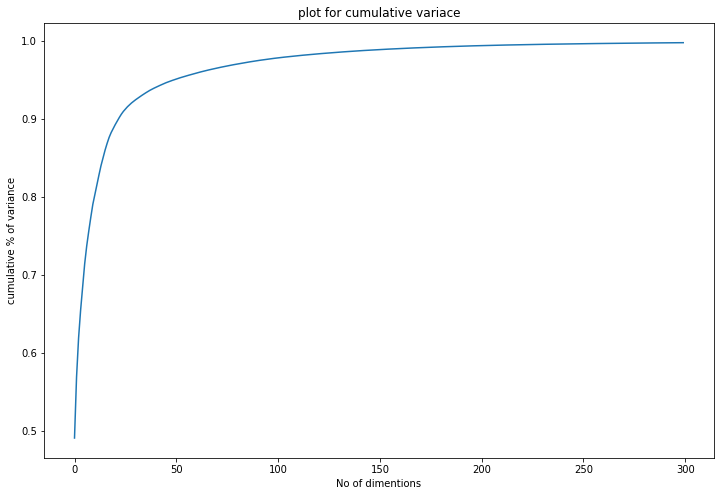

In [20]:
%matplotlib inline
plt.figure(figsize=(12,8))
plt.plot(range(300),np.cumsum(svd.explained_variance_ratio_))
plt.xlabel('No of dimentions')
plt.ylabel('cumulative % of variance')
plt.title('plot for cumulative variace')

200 dimensions are giving 99.382732% of variance so selected 200 dimentons 

In [21]:
svd = TruncatedSVD(n_components=200, n_iter=7, random_state=42)
svd.fit(out_com_5000)

TruncatedSVD(algorithm='randomized', n_components=200, n_iter=7,
       random_state=42, tol=0.0)

In [22]:
vectors_5000 = svd.transform(out_com_5000)

In [23]:
vectors_5000.shape

(5000, 200)

In [24]:
#word 2 vectors dict
W2V_200d = {}
j = 0
for i in top_tfidf_5000:
    W2V_200d[i] = vectors_5000[j]
    j = j + 1

In [25]:
W2V_200d['good']

array([ 2.30734671e+04, -7.29411646e+03, -6.01205311e+02, -2.91414395e+03,
       -1.44238755e+03,  3.30397721e+03,  1.16156135e+03, -3.67082921e+02,
        5.54728757e+02,  8.33438869e+03, -7.23911539e+02,  2.30180690e+02,
       -1.15937250e+03,  4.83762038e+02,  1.88008930e+03,  1.04665332e+03,
       -1.60131388e+02,  1.67060156e+02, -6.18571773e+01,  1.72760239e+02,
        4.26139472e+02,  8.35838750e+01, -1.10007106e+02, -2.49080558e+02,
        4.07044904e+02,  1.23635279e+03, -5.08755322e+00,  1.41321643e+02,
       -1.22399627e+02,  6.69141532e+02,  1.87272444e+01, -4.84492008e+01,
       -5.21832221e+02, -2.70484219e+01,  2.61321650e+02, -3.73168245e+01,
       -5.44854813e+01, -2.28863190e+02, -4.21262862e+00,  8.90183825e+01,
       -1.92961371e+01, -1.02803533e+02,  1.48801412e+00, -2.61718842e+01,
       -9.35980648e+01, -3.66381368e+01,  8.29246153e+01, -3.54183138e+01,
        1.47692135e+02,  4.44313086e+01, -9.81158240e+01,  2.26283878e+02,
       -1.10467277e+02,  

In [190]:
#k-means
from sklearn.cluster import KMeans
ssd = {}
centers = {}
for k in range(1,31):
    model = KMeans(n_clusters=k,n_init=10,max_iter=800,random_state=25,n_jobs=-1)
    model.fit(vectors_5000)
    ssd[k] = model.inertia_
    centers[k] = model.cluster_centers_
    print('No of clusters',k,'Sum of Squared dist',model.inertia_)

No of clusters 1 Sum of Squared dist 9428289184.853857
No of clusters 2 Sum of Squared dist 6621414429.068955
No of clusters 3 Sum of Squared dist 5416518729.075272
No of clusters 4 Sum of Squared dist 4819219983.454041
No of clusters 5 Sum of Squared dist 4354714424.089521
No of clusters 6 Sum of Squared dist 4105793708.77328
No of clusters 7 Sum of Squared dist 3865728087.517543
No of clusters 8 Sum of Squared dist 3597636243.6159244
No of clusters 9 Sum of Squared dist 3434245727.8633146
No of clusters 10 Sum of Squared dist 3258788412.2877645
No of clusters 11 Sum of Squared dist 3148526471.07439
No of clusters 12 Sum of Squared dist 3007827507.167363
No of clusters 13 Sum of Squared dist 2869336322.5125203
No of clusters 14 Sum of Squared dist 2761435699.8483777
No of clusters 15 Sum of Squared dist 2620019538.4262853
No of clusters 16 Sum of Squared dist 2506562419.822661
No of clusters 17 Sum of Squared dist 2367180074.5911613
No of clusters 18 Sum of Squared dist 2284516436.399

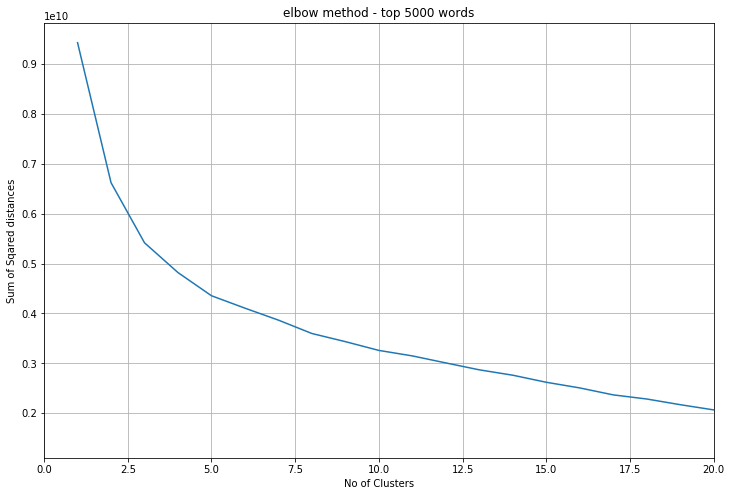

In [191]:
plt.figure(figsize=(12,8))
plt.plot(list(ssd.keys()),list(ssd.values()))
plt.xlim(0,20)
plt.xlabel('No of Clusters')
plt.ylabel('Sum of Sqared distances')
plt.title('elbow method - top 5000 words')
plt.grid()

no of clusters = 4 may be good choice from elbow diagram

In [220]:
model = KMeans(n_clusters=4,n_init=10,max_iter=800,random_state=25,n_jobs=-1)
model.fit(vectors_5000)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=800,
    n_clusters=4, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=25, tol=0.0001, verbose=0)

In [221]:
labels = model.labels_
labels

array([2, 0, 0, ..., 0, 0, 0])

In [222]:
#creating data frame
final_data_5000 = pd.DataFrame(np.hstack((np.array(top_tfidf_5000).reshape(-1,1),
                             vectors_5000,labels.reshape(-1,1))))

In [223]:
#groupby
grp = final_data_5000.groupby(201)[0]

In [224]:
grp.count()

201
0    4901
1       2
2       3
3      94
Name: 0, dtype: int64

In [226]:
grp.get_group('0').sample(30)

1481        chive
1931    limewater
279         amish
4404      powered
1938         quit
1373     turmeric
2831       glutin
4829         zeus
2665     lucianne
1161      lasagna
4463         chop
3171         hots
1109      bermuda
4752       talent
4621       outran
3371       russia
1855         belt
1371          eel
852        burger
4370       dolent
1958     valerian
1473       nougat
3358       bucket
3502          mim
4237     fernwood
3257     tandoori
1020    mirabelle
4623        bemba
4090      puttier
1294         gyro
Name: 0, dtype: object

In [227]:
grp.get_group('1')

632       tea
815    coffee
Name: 0, dtype: object

In [228]:
grp.get_group('2')

0        good
4        love
1280    great
Name: 0, dtype: object

In [229]:
grp.get_group('3')

9            really
12             salt
22        delicious
54              hot
124           yummy
198         organic
211           bread
260            rice
408           decaf
490             cat
502            deal
516           honey
529             nut
582           drink
592           happy
624            milk
760         coconut
809           tasty
832       chocolate
886            bean
919            soup
931            chip
949             dog
961            real
997            item
1006            bar
1139           work
1151            bag
1174          cooky
1190          candy
           ...     
2766         strong
2799            new
2839           iced
2886          value
2931           pack
2978           easy
3031           more
3032       purchase
3042     ingredient
3168           come
3324         bottle
3334    alternative
3359       flavored
3449           size
3612            bad
3640          enjoy
3678      breakfast
3709         gluten
3758          green


We can obsever some similar words in clusters, like  
0 - some miscellaneous fetures of products  
1 - giving tea coffe that are similar products  
2 - giving godd love great, these are also similar words  
3 - these are some words to decribe about produts.  

In [26]:
#similar words for good
top_similar_words(W2V_200d['good'],vectors_5000,10,top_tfidf_5000)

['enjoy',
 'enjoying',
 'fantastic',
 'amazing',
 'fabulous',
 'nice',
 'delicious',
 'incredible',
 'outstanding',
 'perk']

In [28]:
#similar words for sep
top_similar_words(W2V_200d['sep'],vectors_5000,10,top_tfidf_5000)

['dec',
 'aug',
 'august',
 'november',
 'sept',
 'february',
 'expired',
 'expiry',
 'exp',
 'expiration']

In [27]:
#similar words
for i in top_tfidf_5000:
    print('Similar words for',i)
    print(top_similar_words(W2V_200d[i],vectors_5000,10,top_tfidf_5000))

Similar words for good
['enjoy', 'enjoying', 'fantastic', 'amazing', 'fabulous', 'nice', 'delicious', 'incredible', 'outstanding', 'perk']
Similar words for yum
['yummy', 'delish', 'awesome', 'org', 'everybody', 'addictive', 'wow', 'amazing', 'addicted', 'fantastic']
Similar words for aa
['sign', 'laugh', 'sounded', 'umm', 'dependable', 'really', 'mm', 'overprice', 'skilledretired', 'zataraine']
Similar words for word
['agree', 'possibly', 'okay', 'opinion', 'question', 'true', 'further', 'star', 'surely', 'clot']
Similar words for love
['lui', 'obsessed', 'spoiled', 'finally', 'go', 'video', 'medicine', 'agree', 'happy', 'digestive']
Similar words for banana
['slice', 'muffin', 'blueberry', 'mumm', 'strawberry', 'bake', 'homemade', 'frozen', 'walnut', 'crumb']
Similar words for bole
['roosted', 'elbow', 'setpoint', 'decency', 'dreamfields', 'dreamfield', 'orecchiette', 'salame', 'linguine', 'penne']
Similar words for mm
['umm', 'sounded', 'dang', 'really', 'verry', 'amazingly', 'org',

['pilaf', 'furikake', 'sushi', 'risotto', 'basmati', 'ben', 'gaba', 'rasa', 'idly', 'riceselect']
Similar words for gnocchi
['israeli', 'pasta', 'couscous', 'everybody', 'artichoke', 'ackee', 'cornbread', 'yum', 'pickle', 'org']
Similar words for woof
['flossies', 'greenies', 'dentastix', 'chewies', 'chihuahua', 'maltese', 'chewnola', 'cavalier', 'dachshund', 'scottie']
Similar words for heart
['agree', 'okay', 'really', 'win', 'word', 'hmm', 'book', 'finally', 'wise', 'star']
Similar words for hug
['everybody', 'hubby', 'yum', 'yummy', 'girl', 'org', 'dummy', 'daughter', 'kid', 'grandkids']
Similar words for rhubarb
['gooseberry', 'mincemeat', 'whoopie', 'crust', 'cobbler', 'mince', 'thanksgiving', 'boysenberry', 'trifle', 'jam']
Similar words for nitella
['yum', 'cooky', 'bugle', 'yumminess', 'yummy', 'nuttzo', 'heaven', 'spread', 'brownie', 'creamy']
Similar words for stamp
['medjool', 'expiration', 'expiry', 'exp', 'aug', 'february', 'sep', 'dec', 'august', 'expired']
Similar words

['spicy', 'salsa', 'texas', 'pickle', 'horseradish', 'nori', 'chili', 'mustard', 'spicey', 'warned']
Similar words for tonic
['enhancer', 'smartwater', 'fiji', 'alkaline', 'sasani', 'blk', 'seltzer', 'penta', 'faucet', 'distilled']
Similar words for spree
['cotton', 'sweetarts', 'nerd', 'airhead', 'buffet', 'cigarette', 'smarties', 'retro', 'ardor', 'necklace']
Similar words for pea
['asparagus', 'lentil', 'mushroom', 'squash', 'okra', 'wakame', 'base', 'cabbage', 'leek', 'broccoli']
Similar words for gin
['cocktail', 'cola', 'fizzy', 'clot', 'kinda', 'ting', 'cytoma', 'sour', 'rootbeer', 'soda']
Similar words for bacon
['spam', 'smoked', 'pickle', 'salty', 'sprinkle', 'heart', 'season', 'yum', 'seasoned', 'ham']
Similar words for ashby
['dyeing', 'purr', 'alternative', 'poundcake', 'impar', 'cody', 'amy', 'cholestoff', 'sadness', 'seasoned']
Similar words for pug
['dachshund', 'schnauzer', 'pomeranian', 'chihuahua', 'maltese', 'yorkie', 'corgi', 'pup', 'shiatzu', 'husky']
Similar word

['flavorlove', 'bragi', 'mimicreme', 'sakia', 'alca', 'ballistics', 'humidor', 'mozambique', 'dapsang', 'stroopies']
Similar words for clove
['cardamom', 'nutmeg', 'allspice', 'cardamon', 'turmeric', 'cassia', 'tumeric', 'anise', 'saigon', 'coriander']
Similar words for tuna
['fish', 'salmon', 'sardine', 'mayo', 'mayonnaise', 'appetizer', 'fillet', 'gravy', 'meat', 'mackerel']
Similar words for washed
['rinse', 'conditioner', 'salon', 'scalp', 'greasy', 'angel', 'blow', 'sheen', 'shampoo', 'comb']
Similar words for caraway
['poppy', 'chia', 'flax', 'spitz', 'germinate', 'bigs', 'sprouting', 'sunflower', 'sesame', 'hulled']
Similar words for smarties
['nerd', 'cotton', 'runt', 'warhead', 'airhead', 'redlines', 'spree', 'cigarette', 'lum', 'brachs']
Similar words for flavour
['unique', 'smokey', 'agree', 'smoky', 'fruity', 'amazing', 'nice', 'true', 'opinion', 'okay']
Similar words for bread
['cornbread', 'pantry', 'pretzel', 'breadcrumb', 'pasta', 'muffin', 'scone', 'option', 'gnocchi',

['anchovy', 'martini', 'sardine', 'brine', 'tapenade', 'tahini', 'aioli', 'eggplant', 'cooking', 'sue']
Similar words for finnigan
['dyeing', 'purr', 'alternative', 'poundcake', 'impar', 'cody', 'amy', 'cholestoff', 'sadness', 'seasoned']
Similar words for gumma
['gummy', 'techno', 'harico', 'hairdo', 'naked', 'goldilocks', 'tropifrutti', 'trilli', 'noms', 'starbursts']
Similar words for lingonberry
['jam', 'preserve', 'org', 'amazingly', 'sucker', 'really', 'ridiculously', 'hmm', 'halva', 'falafel']
Similar words for thankyou
['thank', 'thanks', 'business', 'vender', 'subscription', 'poor', 'shipper', 'seller', 'promised', 'provider']
Similar words for fig
['chewy', 'apricot', 'trail', 'newton', 'nut', 'scrumptious', 'cookie', 'candy', 'moist', 'crisp']
Similar words for evermore
['sport', 'electrolyte', 'energy', 'cytoma', 'powerade', 'quench', 'recovery', 'hydration', 'eggery', 'celsius']
Similar words for carob
['cacao', 'choc', 'kale', 'semi', 'nib', 'cooky', 'cocoa', 'nesquik', '

['caesar', 'carding', 'catalina', 'vinaigrette', 'ranch', 'ken', 'insalata', 'vinegarette', 'waff', 'coleslaw']
Similar words for leak
['plastic', 'transfer', 'storage', 'busted', 'reuse', 'paper', 'fridge', 'unsealed', 'envelope', 'compost']
Similar words for tulsi
['numb', 'chamomile', 'herbal', 'oolong', 'yogi', 'rooibos', 'rishi', 'darjeeling', 'perh', 'lapsang']
Similar words for sachiez
['adaptogens', 'cheese', 'zesty', 'tangy', 'cheesy', 'brava', 'gulden', 'ketchup', 'jalapeno', 'elbow']
Similar words for medjools
['rabbit', 'plum', 'scrod', 'bons', 'pastina', 'ellas', 'macaw', 'lebkuchen', 'baby', 'cocoquik']
Similar words for papaya
['pineapple', 'mango', 'pear', 'blueberry', 'cranberry', 'apricot', 'prune', 'berry', 'strawberry', 'pomegranate']
Similar words for cassoulet
['seen', 'yognaughts', 'jina', 'chorizo', 'written', 'chickpea', 'hock', 'gnocchi', 'conch', 'crow']
Similar words for funnel
['urinal', 'rum', 'cayman', 'decorate', 'fantasticate', 'confetti', 'drake', 'ici

['sachet', 'bengal', 'snowflake', 'hay', 'aromatherapy', 'musty', 'herb', 'dank', 'single', 'tin']
Similar words for soyrizo
['tomolives', 'triplet', 'grandchild', 'kid', 'pooching', 'grandkids', 'tapa', 'saladitos', 'cocoquik', 'doxy']
Similar words for lentil
['minestrone', 'pea', 'miso', 'amy', 'base', 'mushroom', 'dashi', 'noodle', 'wakame', 'stew']
Similar words for cherri
['dyeing', 'purr', 'alternative', 'poundcake', 'impar', 'cody', 'amy', 'cholestoff', 'sadness', 'seasoned']
Similar words for fontal
['dyeing', 'purr', 'alternative', 'poundcake', 'impar', 'cody', 'amy', 'cholestoff', 'sadness', 'seasoned']
Similar words for sauerkraut
['kraut', 'brat', 'relish', 'pickle', 'freaking', 'bun', 'texas', 'spicy', 'sausage', 'hungarian']
Similar words for weber
['blackened', 'creole', 'rub', 'fajita', 'jerk', 'johnny', 'cajun', 'veleta', 'outback', 'steakhouse']
Similar words for stride
['trident', 'spry', 'orbit', 'dentine', 'sugarless', 'mastic', 'glee', 'xylichew', 'bubble', 'reca

['thank', 'pricing', 'option', 'bargain', 'seller', 'kudos', 'packaging', 'item', 'overpriced', 'work']
Similar words for boldo
['hojicha', 'adagio', 'lapsang', 'chrysanthemum', 'avalon', 'loose', 'steeper', 'buyi', 'eh', 'herbal']
Similar words for yan
['mm', 'umm', 'wugg', 'dang', 'saucisson', 'cava', 'org', 'orthene', 'floosies', 'healthygreat']
Similar words for colombina
['dyeing', 'purr', 'alternative', 'poundcake', 'impar', 'cody', 'amy', 'cholestoff', 'sadness', 'seasoned']
Similar words for cat
['dog', 'pup', 'yorkies', 'she', 'puppy', 'yorkie', 'gizmo', 'grandchild', 'doggy', 'doxy']
Similar words for whoopie
['crust', 'mincemeat', 'gooseberry', 'mince', 'rhubarb', 'turducken', 'moon', 'pumpkin', 'thanksgiving', 'dough']
Similar words for ono
['amazingly', 'freaking', 'org', 'addicting', 'nom', 'mm', 'creole', 'pappy', 'stroopwafels', 'sambar']
Similar words for dill
['pickle', 'radish', 'chive', 'cilantro', 'sprout', 'zesty', 'cumin', 'asparagus', 'cucumber', 'coriander']
Si

['alfredo', 'basting', 'satay', 'nandow', 'carbonara', 'enchilada', 'cattleman', 'matsu', 'charkas', 'peri']
Similar words for tortilla
['potato', 'plantain', 'pita', 'fanfreakintastic', 'kale', 'friths', 'bucko', 'yogavive', 'lay', 'ruffle']
Similar words for seizure
['baneful', 'firstmate', 'canidae', 'pedigree', 'cesar', 'pigg', 'sick', 'vet', 'eukanuba', 'dentastix']
Similar words for pate
['feast', 'friskiest', 'meow', 'catfoot', 'weruva', 'scratcher', 'feline', 'catnip', 'cosmic', 'litter']
Similar words for passover
['dog', 'mom', 'girl', 'yummy', 'cat', 'grandchild', 'grandkids', 'everybody', 'mini', 'awesome']
Similar words for tortellini
['ham', 'ravioli', 'boxed', 'paneler', 'nacho', 'parmesan', 'hummus', 'velveeta', 'dip', 'mozzarella']
Similar words for chickweed
['relaxing', 'steeper', 'camomile', 'relax', 'sleepy', 'detox', 'senna', 'kava', 'herbal', 'lapsang']
Similar words for hojicha
['kukicha', 'tulsi', 'rooibos', 'numb', 'oolong', 'chamomile', 'stash', 'herbal', 'yo

['tee', 'peppercorn', 'coffee', 'supergood', 'gal', 'rev', 'wow', 'fresh', 'okay', 'packaging']
Similar words for measurement
['measure', 'half', 'packet', 'drop', 'equal', 'gal', 'mark', 'average', 'same', 'single']
Similar words for pen
['marker', 'catch', 'dot', 'fondant', 'game', 'fall', 'mom', 'finger', 'ring', 'continues']
Similar words for maui
['master', 'community', 'teeccino', 'turkish', 'raven', 'decaff', 'cuban', 'weaver', 'millstone', 'oclock']
Similar words for tiramisu
['cupcake', 'frosting', 'icecream', 'creme', 'dessert', 'icing', 'hazelnut', 'whipped', 'biscotti', 'pudding']
Similar words for icing
['frosting', 'cupcake', 'rum', 'decorate', 'decoration', 'twinkie', 'zebra', 'fondant', 'flourless', 'funnel']
Similar words for expired
['sept', 'dated', 'august', 'dec', 'february', 'november', 'aug', 'sep', 'expiring', 'expires']
Similar words for charger
['dependable', 'sign', 'laugh', 'sounded', 'environment', 'really', 'verry', 'packaging', 'halva', 'emergency']
Simil

['waxy', 'minstrel', 'godiva', 'leonidas', 'gnosis', 'fager', 'calebaut', 'ritter', 'ghiradelli', 'lyn']
Similar words for coondog
['overprice', 'fogbustin', 'sounded', 'candidate', 'laugh', 'umm', 'costellinis', 'zataraine', 'peased', 'philomenafriend']
Similar words for kenya
['boldness', 'decaff', 'colombian', 'columbian', 'gevalia', 'decaf', 'bodied', 'sumatra', 'columbia', 'community']
Similar words for clark
['mar', 'scrunchie', 'wurly', 'luna', 'mitzvah', 'payday', 'musketeer', 'snicker', 'cliff', 'bionutritional']
Similar words for tamale
['fireball', 'sauce', 'flaming', 'atomic', 'gochujang', 'unbearably', 'spicy', 'spicey', 'relish', 'frank']
Similar words for kojis
['storage', 'freshness', 'composting', 'muslin', 'starter', 'mailing', 'morel', 'packaging', 'drawstring', 'compost']
Similar words for cocohydro
['tonic', 'faucet', 'fiji', 'sasani', 'smartwater', 'metromint', 'alkaline', 'enhancer', 'distilled', 'batteled']
Similar words for hoagie
['bun', 'flaming', 'relish', '

['carmel', 'heaven', 'creme', 'combination', 'wafer', 'fudge', 'milkshake', 'butterscotch', 'scrumptious', 'icecream']
Similar words for easymac
['grandchild', 'latke', 'tobteachable', 'kid', 'sammy', 'ruff', 'grandkids', 'marmite', 'rover', 'nuttela']
Similar words for debbie
['trail', 'flight', 'hiking', 'aim', 'slim', 'size', 'messy', 'smile', 'mealy', 'power']
Similar words for biscuit
['treat', 'bone', 'chew', 'woof', 'pedigree', 'buddy', 'toy', 'pig', 'busy', 'flossies']
Similar words for jerked
['jerky', 'corned', 'tendon', 'mongolian', 'bullion', 'pastrami', 'brisket', 'goulash', 'sausage', 'wheres']
Similar words for dreambones
['breathalicious', 'lambies', 'chewies', 'supergravy', 'marrowbone', 'dentastix', 'hera', 'derrick', 'woof', 'cesar']
Similar words for opalina
['dyeing', 'purr', 'alternative', 'poundcake', 'impar', 'cody', 'amy', 'cholestoff', 'sadness', 'seasoned']
Similar words for custard
['icecream', 'homemade', 'pudding', 'baking', 'mexican', 'smoothy', 'cupcake'

['kid', 'grandkids', 'pooching', 'sammy', 'triplet', 'hubby', 'everybody', 'foodstores', 'picdog', 'droewors']
Similar words for dme
['dyeing', 'purr', 'alternative', 'poundcake', 'impar', 'cody', 'amy', 'cholestoff', 'sadness', 'seasoned']
Similar words for stuffing
['sausage', 'hotdog', 'homemade', 'burger', 'ham', 'gravy', 'meat', 'crock', 'go', 'finger']
Similar words for raisin
['oat', 'quaker', 'crunch', 'walnut', 'muffin', 'cookie', 'frosted', 'crunchy', 'pecan', 'cluster']
Similar words for sheen
['conditioner', 'scalp', 'shampoo', 'greasy', 'washed', 'skin', 'salon', 'moisturizer', 'softness', 'angel']
Similar words for sumatran
['verona', 'sumatra', 'obsidian', 'timothy', 'jet', 'rev', 'magic', 'columbian', 'colombian', 'bold']
Similar words for clementine
['hizzes', 'grape', 'concentrate', 'grapefruit', 'carbonation', 'spritzer', 'bluebird', 'tangerine', 'cere', 'lime']
Similar words for orzo
['couscous', 'fusilli', 'roi', 'tinkyada', 'spiral', 'fettuccine', 'rigatoni', 'qui

['cheesecake', 'pizza', 'char', 'thanksgiving', 'pumpkinhead', 'offseason', 'spice', 'gingerbread', 'cobbler', 'eggnog']
Similar words for yogourmet
['chobani', 'greek', 'bilious', 'kefir', 'starter', 'cheesecloth', 'yogurt', 'parfait', 'yoghurt', 'frozen']
Similar words for melba
['grandson', 'son', 'nephew', 'kiddos', 'pickle', 'gnocchi', 'daughter', 'kid', 'toddler', 'hummus']
Similar words for brat
['sauerkraut', 'treat', 'kielbasa', 'bun', 'relish', 'kraut', 'mad', 'burger', 'sausage', 'biscuit']
Similar words for crape
['gapper', 'waffle', 'buttermilk', 'krusteaz', 'garveys', 'malted', 'batteled', 'muffin', 'alkaline', 'distilled']
Similar words for sue
['martini', 'dirty', 'tapa', 'kid', 'everybody', 'marmite', 'caper', 'grandchild', 'anchovy', 'grandkids']
Similar words for skunk
['pee', 'failure', 'apartment', 'vomit', 'raccoon', 'poop', 'chow', 'stinky', 'crack', 'poo']
Similar words for dora
['sister', 'mom', 'tulip', 'decorate', 'grandma', 'daughter', 'granddaughter', 'birt

['nori', 'kipper', 'salty', 'sensible', 'shale', 'flight', 'booty', 'munchies', 'tasty', 'polar']
Similar words for henry
['dandy', 'nantucket', 'daybreak', 'musketeer', 'payday', 'scrunchie', 'butterfingers', 'snicker', 'clark', 'wurly']
Similar words for cajun
['chili', 'spicy', 'creole', 'chilli', 'jerk', 'hotness', 'salsa', 'harissa', 'texas', 'spicey']
Similar words for annatto
['carmine', 'maltodextrin', 'tumeric', 'sorbic', 'preservative', 'turmeric', 'msg', 'sulfites', 'artificial', 'glycol']
Similar words for miso
['bookbinder', 'minestrone', 'baxters', 'worthmore', 'bors', 'dashi', 'wakame', 'cuginos', 'amy', 'stew']
Similar words for item
['seller', 'thanks', 'option', 'packaging', 'pricing', 'promised', 'case', 'quantity', 'overpriced', 'kudos']
Similar words for cornichons
['loaf', 'pumpernickel', 'sourdough', 'crumb', 'pinko', 'naan', 'breadmaker', 'slicer', 'rise', 'silvan']
Similar words for disposakups
['carousel', 'drawer', 'organizer', 'gadget', 'cupper', 'office', '

['title', 'favourite', 'cuppa', 'london', 'tip', 'unusual', 'match', 'bag', 'keen', 'british']
Similar words for mya
['wellsites', 'chewnola', 'jeffs', 'lammy', 'butler', 'duke', 'everlasting', 'pooch', 'slims', 'quackers']
Similar words for korma
['tempura', 'satay', 'enchilada', 'steak', 'meatball', 'taco', 'alfredo', 'tonkatsu', 'stubbs', 'jerk']
Similar words for nito
['skim', 'sanalac', 'condensed', 'parmalat', 'horlicks', 'goat', 'production', 'capachino', 'aerolatte', 'malted']
Similar words for kale
['plantain', 'potato', 'tortilla', 'fanfreakintastic', 'yogavive', 'pita', 'bucko', 'lay', 'ruffle', 'seneca']
Similar words for monster
['rockstar', 'fear', 'celsius', 'golazo', 'fr', 'spartan', 'zipfizz', 'bawls', 'redbill', 'dew']
Similar words for cough
['maple', 'amoretti', 'karo', 'torans', 'orgeat', 'davinci', 'grade', 'corn', 'vinci', 'alapa']
Similar words for hansen
['dyeing', 'purr', 'alternative', 'poundcake', 'impar', 'cody', 'amy', 'cholestoff', 'sadness', 'seasoned']


['camping', 'lunchboxes', 'hiking', 'starter', 'alternative', 'work', 'snack', 'option', 'bargain', 'emergency']
Similar words for vitacoco
['vita', 'zinco', 'coco', 'nirvana', 'cocoloco', 'ficos', 'zola', 'pulp', 'alkaline', 'tonic']
Similar words for yunnan
['assam', 'impar', 'darjeeling', 'lichee', 'lapsang', 'oolong', 'numb', 'herbal', 'green', 'perh']
Similar words for stain
['medicine', 'continues', 'test', 'off', 'anxiety', 'careful', 'okay', 'forever', 'star', 'catch']
Similar words for msc
['dyeing', 'purr', 'alternative', 'poundcake', 'impar', 'cody', 'amy', 'cholestoff', 'sadness', 'seasoned']
Similar words for waffies
['mac', 'macaroni', 'havarti', 'raclette', 'bleu', 'nacho', 'mascarpone', 'parmesan', 'gouda', 'limburger']
Similar words for caramilk
['chimp', 'hugo', 'dove', 'hershey', 'chimpanzee', 'granola', 'ski', 'snicker', 'scrunchie', 'mar']
Similar words for chowder
['bisque', 'mexico', 'clam', 'zatarain', 'gumbo', 'base', 'york', 'improved', 'mr', 'minestrone']
Sim

['glutamate', 'preservative', 'natural', 'filler', 'gelatin', 'listing', 'chemical', 'maltodextrin', 'smoke', 'simple']
Similar words for casing
['environment', 'tube', 'packaging', 'disaster', 'ingredient', 'finger', 'plant', 'kit', 'starter', 'fence']
Similar words for powder
['powered', 'powdered', 'shake', 'equal', 'soymilk', 'scoop', 'create', 'ordinary', 'culture', 'dutch']
Similar words for tache
['raisinetts', 'ardor', 'leather', 'vie', 'twisted', 'spunch', 'cotton', 'necklace', 'smooshed', 'punch']
Similar words for lemon
['orange', 'pomegranate', 'mangosteen', 'blackberry', 'blackcurrant', 'lemony', 'grapefruit', 'aloe', 'lime', 'pineapple']
Similar words for ballistics
['mimicreme', 'sakia', 'flavorlove', 'bragi', 'fastgreat', 'alca', 'mozambique', 'humidor', 'dapsang', 'stroopies']
Similar words for kookamunga
['sphinx', 'cosmic', 'renal', 'litter', 'meow', 'scratcher', 'bid', 'nip', 'friskiest', 'catnip']
Similar words for faraway
['gunpowder', 'yama', 'invitehealth', 'zen

['bake', 'keeler', 'parchment', 'walker', 'moist', 'dough', 'density', 'broken', 'icing', 'crumbled']
Similar words for cee
['gobble', 'vomited', 'tolerates', 'ignores', 'vomit', 'shed', 'refused', 'fickle', 'underweight', 'refuse']
Similar words for dye
['coloring', 'vine', 'bob', 'bull', 'hots', 'color', 'preservative', 'yellow', 'rain', 'velvet']
Similar words for cinnimony
['streit', 'puttier', 'turion', 'uncontaminated', 'alkalin', 'nutritious', 'stroopwafels', 'diffenitly', 'magically', 'caisson']
Similar words for oil
['castlevetrano', 'manna', 'gemlike', 'tapenade', 'graver', 'martini', 'brine', 'brined', 'macaroon', 'anchovy']
Similar words for nutritious
['healthful', 'satisfying', 'addictive', 'addicting', 'moist', 'magically', 'crunchy', 'convenient', 'amazingly', 'num']
Similar words for luffa
['benzol', 'enzymatic', 'nylabone', 'petrodex', 'hour', 'minichews', 'molar', 'splinter', 'rawhide', 'dental']
Similar words for toro
['anyons', 'crosspacked', 'sicily', 'greece', 'g

['lint', 'toblerone', 'godiva', 'lyn', 'waxy', 'ghiradelli', 'leonidas', 'chimpanzee', 'moonstruck', 'gnosis']
Similar words for cesar
['pedigree', 'chewies', 'baneful', 'dentastix', 'woof', 'bone', 'canidae', 'scottie', 'firstmate', 'pigg']
Similar words for party
['favor', 'gift', 'college', 'student', 'pinata', 'present', 'fun', 'grandparent', 'game', 'memory']
Similar words for decaffeinated
['drinker', 'kenyan', 'mate', 'caffeinated', 'strongest', 'seattle', 'iced', 'drinking', 'decaf', 'southern']
Similar words for repel
['lightsaber', 'charm', 'chipmunk', 'trap', 'dreamwater', 'cakepops', 'carabiner', 'ant', 'gon', 'mosquito']
Similar words for tigger
['mjummie', 'kitty', 'calico', 'mouser', 'mattie', 'kitten', 'roxy', 'misty', 'siamese', 'feast']
Similar words for freshness
['storage', 'come', 'marked', 'same', 'packaging', 'sticker', 'selling', 'received', 'envelope', 'fresh']
Similar words for antler
['nylabones', 'nylabone', 'toy', 'bone', 'rawhide', 'hoof', 'chewies', 'chew

['snack', 'deal', 'vincafe', 'etouffe', 'value', 'alternative', 'camping', 'backpacking', 'fogbustin', 'bargain']
Similar words for dunkin
['dyeing', 'purr', 'alternative', 'poundcake', 'impar', 'cody', 'amy', 'cholestoff', 'sadness', 'seasoned']
Similar words for kellygold
['lurpak', 'nutter', 'peanut', 'snout', 'toffee', 'maranatha', 'stroopwafeln', 'if', 'knife', 'ghee']
Similar words for unsulphered
['bare', 'raisons', 'leather', 'twisted', 'dried', 'phillipsine', 'papaya', 'apricot', 'schnecken', 'smooshed']
Similar words for simplifies
['sandbar', 'grav', 'aachener', 'enjoy', 'gross', 'crackheads', 'good', 'mush', 'disappointing', 'alive']
Similar words for tillman
['duke', 'pooch', 'doggy', 'butler', 'everlasting', 'lammy', 'quackers', 'shelties', 'training', 'potty']
Similar words for sangria
['champagne', 'bargain', 'work', 'alternative', 'introduction', 'camping', 'snack', 'awsome', 'fantastic', 'lemonade']
Similar words for lid
['cap', 'tab', 'spout', 'cover', 'reuse', 'wipe

['urinal', 'decorate', 'funnel', 'cayman', 'rum', 'panettone', 'decoration', 'drake', 'icing', 'cupcake']
Similar words for free
['ppm', 'seitan', 'scd', 'hector', 'pierogi', 'scar', 'namaste', 'dis', 'matzoh', 'non']
Similar words for sauce
['tamale', 'relish', 'flaming', 'gochujang', 'spicy', 'spicey', 'giardiniera', 'unbearably', 'salsa', 'mustard']
Similar words for costo
['pictured', 'selling', 'receive', 'target', 'public', 'picture', 'safeway', 'retail', 'photo', 'transfer']
Similar words for fleischmanns
['dyeing', 'purr', 'alternative', 'poundcake', 'impar', 'cody', 'amy', 'cholestoff', 'sadness', 'seasoned']
Similar words for agree
['okay', 'opinion', 'wow', 'wrong', 'star', 'finally', 'word', 'choice', 'kinda', 'question']
Similar words for nougat
['kiss', 'hershey', 'milky', 'coating', 'kinder', 'ritter', 'dove', 'toblerone', 'waxy', 'lint']
Similar words for batch
['verjuice', 'mistake', 'tuner', 'yep', 'breath', 'yuck', 'kinda', 'possibly', 'yuk', 'smell']
Similar words f

['stash', 'typhoon', 'oolong', 'teabags', 'lapsang', 'british', 'kukicha', 'herbal', 'green', 'chamomile']
Similar words for pike
['medium', 'raggies', 'french', 'rocamojo', 'italian', 'balista', 'verona', 'biodynamic', 'sumatra', 'sumatran']
Similar words for dark
['godiva', 'waxy', 'liquor', 'leonidas', 'moonstruck', 'ghiradelli', 'gnosis', 'ritter', 'minstrel', 'mousse']
Similar words for ornament
['bus', 'variety', 'tub', 'twelve', 'canister', 'portion', 'glove', 'picture', 'tube', 'come']
Similar words for deer
['wipe', 'ripping', 'hat', 'rip', 'leash', 'worn', 'coupon', 'killed', 'tear', 'foot']
Similar words for soursop
['coca', 'loose', 'senna', 'mighty', 'chamomile', 'hibiscus', 'teavana', 'lapsang', 'chrysanthemum', 'adagio']
Similar words for nuttzo
['sunbutter', 'snout', 'if', 'fastachi', 'peter', 'peanut', 'puffin', 'skippy', 'toffee', 'nitella']
Similar words for replacer
['nog', 'ovaeasy', 'panorama', 'scramble', 'quail', 'hashbrowns', 'brinjal', 'buttermilk', 'coddler',

['cola', 'sprite', 'sucker', 'hmm', 'org', 'remembered', 'whiskey', 'gin', 'memory', 'really']
Similar words for whopper
['bar', 'butterscotch', 'smarties', 'violet', 'shell', 'sucker', 'kiss', 'fun', 'rock', 'treater']
Similar words for sina
['reed', 'crystallized', 'crystalized', 'ale', 'snap', 'chime', 'snappish', 'algoid', 'nausea', 'ting']
Similar words for serendipity
['chococino', 'bellagio', 'barra', 'mannheim', 'meltdown', 'cocoa', 'swiss', 'ghiradelli', 'godiva', 'tafa']
Similar words for cholesterol
['total', 'trans', 'sodium', 'carbs', 'gram', 'zero', 'low', 'cals', 'lower', 'gristle']
Similar words for matt
['kitten', 'mouse', 'eve', 'feline', 'nip', 'litter', 'pilling', 'kitty', 'apartment', 'catnip']
Similar words for win
['finally', 'agree', 'really', 'question', 'choice', 'wrong', 'plus', 'book', 'okay', 'star']
Similar words for rubbery
['slimy', 'lasagna', 'mushy', 'tofu', 'ramens', 'fettucini', 'mush', 'ramen', 'kimchi', 'yakisoba']
Similar words for veit
['dyeing',

['diarrhea', 'grooming', 'sick', 'fart', 'uninterested', 'pancreatitis', 'plaque', 'wag', 'ear', 'vet']
Similar words for listing
['fourth', 'check', 'permethrin', 'misleading', 'natural', 'deceptive', 'msg', 'feuillet', 'wholesome', 'roundup']
Similar words for liter
['glass', 'squeeze', 'nozzle', 'sprayer', 'talkingrain', 'neck', 'nipple', 'blk', 'ounce', 'gallon']
Similar words for dreamwater
['lightsaber', 'charm', 'repel', 'gon', 'cakepops', 'agora', 'mandoline', 'carabiner', 'benzocaine', 'trap']
Similar words for fern
['babyfood', 'selectional', 'pacifier', 'gadget', 'sundew', 'fondarific', 'teething', 'toddler', 'mum', 'gift']
Similar words for liq
['currant', 'tiger', 'spagueties', 'treacle', 'forest', 'trumpet', 'ganoclassic', 'licorice', 'baddest', 'te']
Similar words for mimicreme
['mimicreme', 'sakia', 'flavorlove', 'fastgreat', 'alca', 'ballistics', 'humidor', 'mozambique', 'dapsang', 'stroopies']
Similar words for milo
['liver', 'duke', 'lean', 'pooch', 'butler', 'wellsi

['caffeine', 'caffeinated', 'mate', 'decaffeinated', 'everyday', 'drinking', 'awake', 'drinker', 'seattle', 'drink']
Similar words for disc
['frappe', 'watered', 'foam', 'mocha', 'watery', 'creamer', 'frothy', 'hazelnut', 'cup', 'flavored']
Similar words for principe
['archway', 'fortune', 'walker', 'shortbread', 'gingersnap', 'oreo', 'nanas', 'crumbled', 'biscoff', 'salerno']
Similar words for dandyblend
['teeccino', 'cuban', 'community', 'tchibo', 'dallmayr', 'monde', 'raven', 'maxwell', 'master', 'turkish']
Similar words for fart
['sick', 'pedigree', 'baneful', 'tow', 'diarrhea', 'canidae', 'seizure', 'lb', 'schipperke', 'chew']
Similar words for redlines
['smarties', 'nerd', 'cotton', 'airhead', 'lum', 'beady', 'spree', 'necklace', 'horehound', 'warhead']
Similar words for fillet
['fish', 'herring', 'shrimp', 'salmon', 'sardine', 'cod', 'tuna', 'grill', 'meat', 'rub']
Similar words for okra
['asparagus', 'soup', 'mushroom', 'artichoke', 'ham', 'dehydrated', 'pea', 'pickle', 'cucumb

['bearnaise', 'barbecue', 'oisin', 'marinara', 'hollandaise', 'enchilada', 'chimichurri', 'alfredo', 'charkas', 'barbeque']
Similar words for lakewood
['dyeing', 'purr', 'alternative', 'poundcake', 'impar', 'cody', 'amy', 'cholestoff', 'sadness', 'seasoned']
Similar words for cracked
['cayenne', 'tellicherry', 'crushed', 'sichuan', 'ghost', 'paprika', 'oregano', 'telicherry', 'garlic', 'seasoned']
Similar words for tamarin
['endorser', 'droewors', 'foodstores', 'picdog', 'pooching', 'saladitos', 'heezies', 'marmite', 'nonstarch', 'grandchild']
Similar words for prezes
['umm', 'dang', 'jammer', 'skilledretired', 'oxo', 'orthene', 'philomenafriend', 'peased', 'floosies', 'sesamioil']
Similar words for harico
['trilli', 'gumma', 'starbursts', 'gummy', 'techno', 'frog', 'worm', 'noms', 'bear', 'dummy']
Similar words for vincafe
['etouffe', 'fogbustin', 'deal', 'value', 'pricethe', 'kuchela', 'bragi', 'mimicreme', 'flavorlove', 'sakia']
Similar words for katy
['dyeing', 'purr', 'alternative

['poultry', 'crab', 'gyro', 'mock', 'conch', 'grill', 'veggie', 'lobster', 'rub', 'lysander']
Similar words for damson
['preserve', 'jam', 'cavier', 'lingonberry', 'supercharge', 'leather', 'twisted', 'belly', 'boysenberry', 'dried']
Similar words for arsenic
['gogo', 'basmati', 'gaba', 'arborio', 'crispin', 'tamanishiki', 'krispies', 'pilaf', 'riceselect', 'puffed']
Similar words for trivia
['splenia', 'pyrexia', 'nectresse', 'stevia', 'erythritol', 'sucralose', 'saccharine', 'saccharin', 'xylosweet', 'granular']
Similar words for yougart
['snack', 'smoothy', 'vincafe', 'starter', 'camping', 'value', 'yogurt', 'topping', 'deal', 'alternative']
Similar words for run
['much', 'happened', 'surely', 'clot', 'public', 'case', 'word', 'test', 'careful', 'drive']
Similar words for doggy
['pup', 'shelties', 'pooch', 'yorkie', 'yorkies', 'cavalier', 'pug', 'puppy', 'schnauzer', 'chihuahua']
Similar words for wort
['tulsi', 'rishi', 'hibiscus', 'chamomile', 'perh', 'numb', 'detox', 'rooibos', '

['dad', 'father', 'bos', 'parent', 'grandparent', 'sister', 'present', 'mom', 'wife', 'favor']
Similar words for michigan
['manhattan', 'bing', 'tart', 'maraschino', 'cordial', 'invisible', 'switch', 'cola', 'coke', 'lifesaver']
Similar words for gatorade
['dyeing', 'purr', 'alternative', 'poundcake', 'impar', 'cody', 'amy', 'cholestoff', 'sadness', 'seasoned']
Similar words for handout
['hunter', 'berbery', 'fantasticyou', 'pumpkin', 'sumac', 'pickling', 'bumkin', 'nile', 'bengal', 'herb']
Similar words for rou
['jodaman', 'trahana', 'agora', 'whitefly', 'emergency', 'cyclist', 'kipper', 'kleritea', 'verry', 'orthene']
Similar words for guayucky
['patella', 'bbl', 'foxie', 'steelers', 'molar', 'wheezing', 'mongo', 'tail', 'armpit', 'grandfather']
Similar words for sauncier
['celtic', 'fleur', 'maldon', 'realsalt', 'himalayan', 'sarah', 'gris', 'sea', 'da', 'cardia']
Similar words for valerian
['echinacea', 'kava', 'chakra', 'sassafras', 'rosehip', 'sleepytime', 'petal', 'hibiscus', 'g

['amish', 'movie', 'popper', 'cornzapoppin', 'hull', 'theater', 'tommy', 'positivibes', 'theatre', 'snackwells']
Similar words for matsu
['grilling', 'barbecued', 'cutlet', 'rib', 'marinade', 'popeyes', 'jerk', 'grill', 'steak', 'shrimp']
Similar words for cricket
['detail', 'gorry', 'podunk', 'teste', 'roach', 'goaty', 'doubled', 'finncrisp', 'masculine', 'rugelach']
Similar words for noun
['alba', 'hydration', 'avital', 'cytoma', 'work', 'awsome', 'camping', 'kabosu', 'zabihah', 'mixer']
Similar words for ticky
['seizure', 'puzzle', 'havaheart', 'wellsites', 'lammy', 'pedigree', 'cesar', 'chewnola', 'woof', 'baneful']
Similar words for richer
['intense', 'watery', 'expected', 'generic', 'twice', 'harder', 'average', 'ordinary', 'doubled', 'space']
Similar words for swizzle
['bully', 'leo', 'munchy', 'cadet', 'beechy', 'moo', 'glue', 'pixy', 'pepperoni', 'slimjim']
Similar words for casa
['pickle', 'wow', 'chutney', 'ketchup', 'yum', 'sucker', 'freaking', 'asparagus', 'mustard', 'sals

['tub', 'tube', 'bottle', 'case', 'canister', 'bucket', 'tray', 'pouch', 'same', 'original']
Similar words for sensual
['bergamot', 'twinings', 'rishi', 'lavender', 'pickwick', 'exquisite', 'stash', 'darjeeling', 'twinnings', 'flowery']
Similar words for mott
['grape', 'concentrate', 'clementine', 'pear', 'hizzes', 'capri', 'prune', 'welches', 'granny', 'smith']
Similar words for familia
['breadshop', 'grapenuts', 'alpen', 'muesli', 'cestum', 'gorilla', 'wheatens', 'weetabix', 'frosted', 'kashi']
Similar words for donut
['gevalia', 'millstone', 'hazelnut', 'kahlua', 'timothy', 'maxwell', 'community', 'master', 'teeccino', 'colombian']
Similar words for mjummie
['mouser', 'tigger', 'mattie', 'kitty', 'scratcher', 'calico', 'kitten', 'catnip', 'friskiest', 'feast']
Similar words for jellybelly
['formy', 'tobteachable', 'nuttela', 'expansive', 'brook', 'marmite', 'apache', 'jelly', 'salsify', 'gail']
Similar words for block
['shell', 'original', 'missing', 'term', 'goo', 'same', 'group', 

['crystallized', 'snap', 'crystalized', 'reed', 'chime', 'sina', 'snappish', 'nausea', 'pannetone', 'algoid']
Similar words for pilling
['bid', 'sphinx', 'scratcher', 'catnip', 'nip', 'meow', 'litter', 'friskiest', 'feline', 'barf']
Similar words for quiche
['crouton', 'topping', 'scramble', 'dressing', 'slaw', 'lettuce', 'mayo', 'meatloaf', 'sandwich', 'dip']
Similar words for mince
['gooseberry', 'whoopie', 'mincemeat', 'crust', 'rhubarb', 'basil', 'cilantro', 'thanksgiving', 'pumpkin', 'shallot']
Similar words for cookie
['cooky', 'brownie', 'gooey', 'wafer', 'scrumptious', 'fudge', 'marshmallow', 'yumminess', 'chocolatey', 'cake']
Similar words for solid
['further', 'word', 'book', 'possibly', 'agree', 'okay', 'clot', 'opinion', 'test', 'heart']
Similar words for snoqualmie
['dyeing', 'purr', 'alternative', 'poundcake', 'impar', 'cody', 'amy', 'cholestoff', 'sadness', 'seasoned']
Similar words for marge
['loaf', 'pumpernickel', 'breadmaker', 'sourdough', 'pinko', 'silvan', 'crumb',

['sandwich', 'spread', 'bagel', 'banana', 'slicer', 'crumb', 'baguette', 'sourdough', 'bake', 'dip']
Similar words for temptation
['ferret', 'kitty', 'hairball', 'friskiest', 'batboy', 'feline', 'purr', 'meow', 'sphinx', 'catnip']
Similar words for placebo
['pomegranate', 'concentrated', 'insomnia', 'awake', 'orange', 'lemon', 'gout', 'sleep', 'mangosteen', 'hour']
Similar words for skull
['alcohol', 'crash', 'laden', 'blood', 'spike', 'absinthe', 'demerara', 'refined', 'coma', 'granulated']
Similar words for organ
['clot', 'click', 'choice', 'finally', 'non', 'win', 'awesome', 'desert', 'okay', 'fantastic']
Similar words for blend
['decaf', 'strong', 'mild', 'robust', 'bodied', 'hotel', 'aroma', 'cup', 'mate', 'collection']
Similar words for smeagol
['pandoor', 'mizuna', 'rabbit', 'kumquat', 'garret', 'scrod', 'cilantro', 'basil', 'latempesta', 'privy']
Similar words for slimy
['mushy', 'mush', 'rubbery', 'slime', 'disgusting', 'gross', 'kinda', 'tofu', 'cooked', 'inedible']
Similar w

['umm', 'dang', 'mm', 'sounded', 'floosies', 'healthygreat', 'costellinis', 'philomenafriend', 'cankersores', 'peased']
Similar words for chokecherry
['belly', 'elderberry', 'jam', 'gimbal', 'prickly', 'saskatoon', 'harry', 'damson', 'guava', 'flop']
Similar words for sam
['gorilla', 'alpen', 'wheatens', 'grapenuts', 'mapo', 'cher', 'kashi', 'cestum', 'breadshop', 'flake']
Similar words for meijer
['dyeing', 'purr', 'alternative', 'poundcake', 'impar', 'cody', 'amy', 'cholestoff', 'sadness', 'seasoned']
Similar words for deceived
['misleading', 'same', 'wrong', 'further', 'equal', 'deceptive', 'ideal', 'missing', 'question', 'mark']
Similar words for aerator
['venturi', 'moscato', 'riesling', 'champagne', 'cork', 'wine', 'sangria', 'kit', 'fini', 'sherry']
Similar words for antixodents
['yapp', 'booster', 'outburst', 'vroom', 'focus', 'karamalz', 'anns', 'bawls', 'crash', 'fear']
Similar words for parmesan
['romano', 'macaroni', 'mozzarella', 'mac', 'havarti', 'bleu', 'feta', 'nacho', 

['energizing', 'refreshing', 'relax', 'relaxing', 'bedtime', 'guayabi', 'fruity', 'everyday', 'palmer', 'lemonade']
Similar words for chipmunk
['raccoon', 'repel', 'flea', 'trap', 'yard', 'litter', 'squirrel', 'carabiner', 'hairball', 'ant']
Similar words for spider
['fly', 'roach', 'catch', 'gnat', 'moth', 'insect', 'pest', 'mole', 'gopher', 'trap']
Similar words for cortas
['dyeing', 'purr', 'alternative', 'poundcake', 'impar', 'cody', 'amy', 'cholestoff', 'sadness', 'seasoned']
Similar words for basted
['pork', 'veal', 'turkey', 'drumstick', 'skewer', 'liver', 'strip', 'nugget', 'broth', 'barbecued']
Similar words for ustashi
['dyeing', 'purr', 'alternative', 'poundcake', 'impar', 'cody', 'amy', 'cholestoff', 'sadness', 'seasoned']
Similar words for quanti
['glutton', 'gluten', 'suisse', 'community', 'dallmayr', 'kahlua', 'master', 'teeccino', 'grapeleaves', 'clock']
Similar words for shark
['heat', 'plate', 'runny', 'sweat', 'texas', 'run', 'cover', 'drop', 'hellmanns', 'horseradis

['loganberry', 'pandoor', 'smeagol', 'zest', 'mizuna', 'remix', 'testy', 'rabbit', 'tcp', 'madeleines']
Similar words for goeties
['spunch', 'treater', 'wut', 'beady', 'butterscotch', 'spree', 'remembered', 'cotton', 'healthygreat', 'costellinis']
Similar words for davidoff
['dyeing', 'purr', 'alternative', 'poundcake', 'impar', 'cody', 'amy', 'cholestoff', 'sadness', 'seasoned']
Similar words for melon
['mango', 'pomegranate', 'strawberry', 'berry', 'peachy', 'fruity', 'blueberry', 'raspberry', 'pineapple', 'watermelon']
Similar words for chobani
['greek', 'yogourmet', 'parfait', 'bilious', 'smoothie', 'yogurt', 'frozen', 'yoghurt', 'smoothy', 'familia']
Similar words for spry
['trident', 'orbit', 'xylichew', 'sugarless', 'dentine', 'stride', 'glee', 'mastic', 'recalment', 'bubble']
Similar words for potato
['tortilla', 'kale', 'plantain', 'pita', 'lay', 'fanfreakintastic', 'bucko', 'yogavive', 'friths', 'ruffle']
Similar words for parmasean
['parmesan', 'feta', 'romano', 'bleu', 'moz

['flavour', 'background', 'mild', 'selection', 'smoky', 'assortment', 'kick', 'smokey', 'fantastic', 'combination']
Similar words for wyson
['eve', 'weruva', 'bid', 'wellness', 'barf', 'renal', 'failure', 'friskiest', 'sphinx', 'halo']
Similar words for moca
['frappuccino', 'francais', 'illy', 'jolies', 'spartan', 'cappuccino', 'teeccino', 'monster', 'rockstar', 'calix']
Similar words for dang
['umm', 'mm', 'verry', 'sounded', 'wicked', 'laugh', 'cankersores', 'zataraine', 'sesamioil', 'peased']
Similar words for theater
['theatre', 'movie', 'popper', 'bambino', 'tommy', 'hull', 'amish', 'cornzapoppin', 'flavanol', 'cretons']
Similar words for sparkling
['seltzer', 'carbonating', 'swamp', 'concentrate', 'perrier', 'tonic', 'zola', 'sasani', 'enhancer', 'alkaline']
Similar words for tab
['tear', 'lid', 'wipe', 'come', 'mark', 'cover', 'finger', 'messy', 'screen', 'star']
Similar words for allegory
['csftdls', 'arf', 'worthing', 'allergy', 'vincafe', 'alca', 'evangel', 'flavorlove', 'sak

['camp', 'toucan', 'movie', 'smarties', 'theatre', 'theater', 'violet', 'grandkids', 'tommy', 'nerd']
Similar words for smooth
['bodied', 'aroma', 'robust', 'strong', 'rich', 'decaf', 'acidic', 'weak', 'mild', 'flavored']
Similar words for drake
['cayman', 'funnel', 'urinal', 'rum', 'fantasticate', 'decorate', 'confetti', 'decoration', 'icing', 'panettone']
Similar words for teaching
['love', 'lui', 'finally', 'choice', 'fence', 'agree', 'continues', 'game', 'go', 'convince']
Similar words for sampler
['variety', 'canister', 'selection', 'assortment', 'collection', 'opportunity', 'single', 'sample', 'tin', 'classic']
Similar words for talkingrain
['blk', 'sasani', 'distiller', 'seltzer', 'perrier', 'liter', 'penta', 'fiji', 'tonic', 'smartwater']
Similar words for neumann
['dyeing', 'purr', 'alternative', 'poundcake', 'impar', 'cody', 'amy', 'cholestoff', 'sadness', 'seasoned']
Similar words for irn
['dyeing', 'purr', 'alternative', 'poundcake', 'impar', 'cody', 'amy', 'cholestoff', 's

['overpriced', 'pricing', 'bargain', 'thanks', 'option', 'quantity', 'item', 'wow', 'seller', 'assortment']
Similar words for welches
['mangosteen', 'concentrate', 'cere', 'clementine', 'mott', 'cero', 'hizzes', 'apple', 'grape', 'sensible']
Similar words for cup
['flavored', 'decaf', 'mug', 'decaff', 'weak', 'turkish', 'unflavored', 'strong', 'mate', 'heartburn']
Similar words for chun
['korean', 'korea', 'tofu', 'base', 'kimchi', 'lentil', 'ramen', 'thai', 'noodle', 'udon']
Similar words for duff
['neuro', 'yahoo', 'sport', 'celsius', 'monster', 'fear', 'recovery', 'golazo', 'zipfizz', 'sonic']
Similar words for carmi
['dyeing', 'purr', 'alternative', 'poundcake', 'impar', 'cody', 'amy', 'cholestoff', 'sadness', 'seasoned']
Similar words for halloween
['buffet', 'ardor', 'cotton', 'islet', 'treater', 'smarties', 'retro', 'cigarette', 'wedding', 'runt']
Similar words for zero
['lower', 'low', 'carbs', 'total', 'cholesterol', 'limit', 'protein', 'sodium', 'cals', 'laden']
Similar words

['dyeing', 'purr', 'alternative', 'poundcake', 'impar', 'cody', 'amy', 'cholestoff', 'sadness', 'seasoned']
Similar words for mob
['biggy', 'don', 'bailey', 'brother', 'tim', 'tassimio', 'gastro', 'kahlua', 'master', 'lung']
Similar words for club
['quit', 'selling', 'wink', 'sale', 'case', 'jones', 'overpriced', 'target', 'supermarket', 'vacation']
Similar words for diego
['tonic', 'enhancer', 'boring', 'warm', 'blk', 'faucet', 'alkaline', 'swamp', 'fiji', 'seltzer']
Similar words for pale
['bright', 'tint', 'amazing', 'fantastic', 'background', 'incredible', 'fabulous', 'combination', 'color', 'delicious']
Similar words for starburst
['nerd', 'smarties', 'airhead', 'starbursts', 'redlines', 'brachs', 'warhead', 'cotton', 'jolly', 'sour']
Similar words for smokesandbooze
['skinner', 'catchmaster', 'moth', 'gopher', 'mole', 'pest', 'bran', 'cluster', 'frosted', 'wasp']
Similar words for hawaiian
['hawaii', 'grinder', 'island', 'amaretto', 'hazelnut', 'frappe', 'accent', 'flavored', 'wo

['dairy', 'allergen', 'gluten', 'glutter', 'luetin', 'pierogi', 'lactose', 'scd', 'dis', 'glucan']
Similar words for homework
['game', 'gross', 'fun', 'okay', 'bank', 'careful', 'kidding', 'worth', 'safe', 'video']
Similar words for wag
['ear', 'tail', 'gobble', 'checkup', 'shed', 'uninterested', 'diarrhea', 'mobility', 'vet', 'grooming']
Similar words for ferrara
['medaglia', 'bustle', 'bustello', 'mona', 'kimbo', 'bialetti', 'capsule', 'lavazza', 'kopek', 'italy']
Similar words for poppadoms
['cricket', 'gorry', 'neuropassion', 'york', 'podunk', 'hashier', 'brigadier', 'teste', 'solicit', 'mexico']
Similar words for flavorlove
['mimicreme', 'sakia', 'flavorlove', 'fastgreat', 'alca', 'ballistics', 'humidor', 'mozambique', 'dapsang', 'stroopies']
Similar words for granary
['zabihah', 'bragi', 'sakia', 'mimicreme', 'flavorlove', 'fastgreat', 'alca', 'teff', 'selectional', 'ballistics']
Similar words for iams
['dyeing', 'purr', 'alternative', 'poundcake', 'impar', 'cody', 'amy', 'choles

['decoration', 'topping', 'tabouli', 'cupcake', 'finger', 'appetizer', 'game', 'snack', 'go', 'work']
Similar words for pipe
['funny', 'perfume', 'pungent', 'fishy', 'musty', 'strange', 'rotten', 'kinda', 'awful', 'menthol']
Similar words for parang
['cincinnati', 'indian', 'skyline', 'dal', 'pad', 'curry', 'vegetarian', 'spicy', 'biryani', 'korma']
Similar words for convince
['finally', 'clot', 'agree', 'question', 'okay', 'surely', 'opinion', 'continues', 'never', 'star']
Similar words for uti
['meow', 'hairball', 'renal', 'litter', 'catfoot', 'siamese', 'friskiest', 'kitten', 'cosmic', 'catnip']
Similar words for feuillet
['permethrin', 'listing', 'daquiri', 'auditor', 'hoc', 'misinformed', 'mozzles', 'fourth', 'roundup', 'email']
Similar words for value
['deal', 'fogbustin', 'vincafe', 'bargain', 'etouffe', 'pricing', 'starter', 'pricethe', 'camping', 'alternative']
Similar words for selling
['sale', 'supermarket', 'case', 'target', 'receive', 'save', 'mistake', 'retail', 'purchase

['bay', 'betel', 'stalk', 'mighty', 'balm', 'uncut', 'gall', 'chard', 'spearmint', 'plant']
Similar words for sucrose
['refined', 'maltitol', 'cane', 'granulated', 'talitol', 'confectioner', 'laden', 'spike', 'blood', 'alcohol']
Similar words for maruchan
['yakisoba', 'shin', 'ramyun', 'ramen', 'goring', 'ramens', 'kimchi', 'noodle', 'korean', 'udon']
Similar words for noise
['gas', 'twice', 'harder', 'catch', 'careful', 'shed', 'solved', 'hilarious', 'continues', 'enthusiasm']
Similar words for cliff
['luna', 'mar', 'wurly', 'nutrigrain', 'clip', 'clark', 'trio', 'bionutritional', 'scrunchie', 'marathon']
Similar words for bellagio
['ghiradelli', 'godiva', 'leonidas', 'minstrel', 'fager', 'calebaut', 'barra', 'tafa', 'liquor', 'gnosis']
Similar words for greece
['crosspacked', 'anyons', 'sicily', 'toro', 'sardine', 'anchovy', 'martini', 'spanish', 'grapeseed', 'canola']
Similar words for saigon
['cassia', 'burmannia', 'cert', 'nutmeg', 'indus', 'allspice', 'clove', 'streusel', 'roll',

['flavorlove', 'sakia', 'mimicreme', 'bragi', 'fastgreat', 'humidor', 'ballistics', 'mozambique', 'dapsang', 'stroopies']
Similar words for malted
['skim', 'nito', 'condensed', 'aerolatte', 'parmalat', 'horlicks', 'production', 'sanalac', 'goat', 'horizon']
Similar words for streusel
['doughnut', 'donut', 'kahlua', 'saigon', 'hazelnut', 'tim', 'flavored', 'amaretto', 'master', 'roll']
Similar words for sicilia
['lime', 'realemon', 'zest', 'curd', 'concentrate', 'bluebird', 'clementine', 'grapefruit', 'kuzu', 'cere']
Similar words for bathroom
['drive', 'catch', 'moving', 'sleep', 'steroid', 'run', 'careful', 'gas', 'function', 'noise']
Similar words for unhappy
['satisfied', 'pleased', 'business', 'corrected', 'receive', 'happy', 'repeat', 'image', 'poor', 'return']
Similar words for jelyman
['zat', 'novus', 'avalon', 'yogi', 'marketspice', 'herbal', 'forte', 'oolong', 'flowering', 'adagio']
Similar words for salem
['italy', 'germany', 'org', 'turion', 'brother', 'hubby', 'everybody', 

['munchy', 'slim', 'thanks', 'pepperoni', 'aim', 'pricing', 'bully', 'bargain', 'awsome', 'sucker']
Similar words for westbrae
['eden', 'pinto', 'mung', 'lima', 'refried', 'adzuki', 'sants', 'fava', 'jelly', 'apache']
Similar words for barra
['bellagio', 'ghiradelli', 'godiva', 'liquor', 'leonidas', 'moonstruck', 'minstrel', 'gnosis', 'serendipity', 'mousse']
Similar words for nabisco
['dyeing', 'purr', 'alternative', 'poundcake', 'impar', 'cody', 'amy', 'cholestoff', 'sadness', 'seasoned']
Similar words for mould
['stamp', 'dated', 'expired', 'sept', 'february', 'freshness', 'sticker', 'november', 'gape', 'aug']
Similar words for bons
['lollipop', 'baby', 'plum', 'puff', 'kid', 'everybody', 'sucker', 'yumpie', 'grandkids', 'koali']
Similar words for chalet
['armee', 'vincafe', 'etouffe', 'mimicreme', 'flavorlove', 'sakia', 'bragi', 'fastgreat', 'alca', 'grilling']
Similar words for kalamatas
['tapenade', 'sue', 'martini', 'brined', 'anchovy', 'caper', 'brine', 'graver', 'castlevetrano

['dog', 'cat', 'gizmo', 'roxy', 'pup', 'doggy', 'sammy', 'pooching', 'shelties', 'yorkie']
Similar words for warua
['dyeing', 'purr', 'alternative', 'poundcake', 'impar', 'cody', 'amy', 'cholestoff', 'sadness', 'seasoned']
Similar words for he
['jake', 'ear', 'oliver', 'tummy', 'digestive', 'buddy', 'poo', 'checkup', 'piggy', 'his']
Similar words for ceylon
['assam', 'tulsi', 'marketspice', 'chamomile', 'herbal', 'darjeeling', 'numb', 'oolong', 'lapsang', 'rooibos']
Similar words for tarter
['tartar', 'plaque', 'kong', 'puzzle', 'buddy', 'vet', 'checkup', 'stinky', 'potty', 'toy']
Similar words for marshfield
['dyeing', 'purr', 'alternative', 'poundcake', 'impar', 'cody', 'amy', 'cholestoff', 'sadness', 'seasoned']
Similar words for renal
['meow', 'hairball', 'cosmic', 'purr', 'sphinx', 'bid', 'siamese', 'friskiest', 'litter', 'feline']
Similar words for come
['same', 'forever', 'original', 'case', 'supermarket', 'tiny', 'selling', 'further', 'okay', 'clot']
Similar words for foray
['r

['cere', 'concentrate', 'calmato', 'clementine', 'kuzu', 'mangosteen', 'realemon', 'grape', 'grapefruit', 'sparkling']
Similar words for stickies
['gorry', 'podunk', 'teste', 'goaty', 'wowzas', 'rugelach', 'cricket', 'masculine', 'prefilled', 'detail']
Similar words for pricing
['bargain', 'thanks', 'overpriced', 'deal', 'seller', 'packaging', 'value', 'option', 'kudos', 'saving']
Similar words for nutritionist
['power', 'combination', 'solid', 'mumm', 'okay', 'dessert', 'bar', 'ideal', 'plus', 'marzipan']
Similar words for parsley
['oregano', 'shallot', 'basil', 'cilantro', 'marjoram', 'onion', 'garlic', 'celery', 'rosemary', 'chive']
Similar words for capellini
['fusilli', 'gamut', 'barley', 'fettuccine', 'rigatoni', 'orzo', 'plum', 'eden', 'arrowhead', 'quinoa']
Similar words for rugelach
['gorry', 'podunk', 'goaty', 'teste', 'masculine', 'kleritea', 'finncrisp', 'cricket', 'formy', 'prefilled']
Similar words for fronter
['enchilada', 'rooster', 'marinara', 'oisin', 'pickapeppa', 'b

['delicious', 'popular', 'bland', 'sol', 'ministry', 'exotic', 'possibly', 'disgusting', 'gingerbread', 'herb']
Similar words for flavourful
['character', 'aromatic', 'earthy', 'mellow', 'exotic', 'malty', 'title', 'mild', 'drinking', 'robust']
Similar words for balista
['vienna', 'verona', 'columbian', 'sumatra', 'expresso', 'maxwell', 'colombian', 'obsidian', 'gevalia', 'columbia']
Similar words for fike
['ethiopian', 'arabica', 'oclock', 'clock', 'dallmayr', 'tarrazu', 'phil', 'grind', 'raven', 'peaberry']
Similar words for yellowrose
['costellinis', 'floosies', 'healthygreat', 'philomenafriend', 'cankersores', 'peased', 'sesamioil', 'zataraine', 'orthene', 'skilledretired']
Similar words for berbery
['hunter', 'handout', 'fantasticyou', 'tunisian', 'pumpkin', 'nile', 'guisada', 'creole', 'bumkin', 'bengal']
Similar words for salon
['conditioner', 'shampoo', 'scalp', 'beauty', 'dandruff', 'greasy', 'angel', 'washed', 'moisturizer', 'softness']
Similar words for smiley
['sample', 'mo

['cup', 'decaff', 'heartburn', 'strong', 'decaf', 'expresso', 'morning', 'bodied', 'robust', 'boldness']
Similar words for criminal
['outrageous', 'handling', 'fee', 'ridiculous', 'expedited', 'ludicrous', 'fast', 'slow', 'debolles', 'coffegiant']
Similar words for steeper
['kukicha', 'camomile', 'tip', 'adagio', 'teabags', 'stash', 'lapsang', 'yogi', 'oolong', 'hojicha']
Similar words for hempseed
['native', 'coconut', 'hexane', 'palm', 'soybean', 'canola', 'plum', 'olive', 'grapeseed', 'eden']
Similar words for beauty
['shampoo', 'conditioner', 'dandruff', 'scalp', 'salon', 'suave', 'moisturizer', 'tropiclean', 'hair', 'comb']
Similar words for bing
['maraschino', 'cordial', 'michigan', 'brandied', 'tart', 'manhattan', 'invisible', 'gout', 'pomegranate', 'watermelon']
Similar words for deo
['dyeing', 'purr', 'alternative', 'poundcake', 'impar', 'cody', 'amy', 'cholestoff', 'sadness', 'seasoned']
Similar words for wrapper
['wax', 'butterfingers', 'cardboard', 'goo', 'candy', 'chalk', 

['gemlike', 'castlevetrano', 'graver', 'tapenade', 'brined', 'oil', 'brine', 'martini', 'crosspacked', 'workman']
Similar words for crostini
['flatbread', 'ritz', 'saltine', 'graham', 'goldfish', 'vinta', 'milton', 'lance', 'otc', 'verygood']
Similar words for palouse
['dyeing', 'purr', 'alternative', 'poundcake', 'impar', 'cody', 'amy', 'cholestoff', 'sadness', 'seasoned']
Similar words for horrifying
['bad', 'awful', 'gross', 'yuck', 'disappointing', 'perk', 'good', 'disgusting', 'mark', 'terrible']
Similar words for vegetarian
['meatless', 'soup', 'vegan', 'gravy', 'sausage', 'chicken', 'meat', 'ham', 'burger', 'tofu']
Similar words for belgian
['vitalicious', 'godiva', 'waxy', 'gnosis', 'leonidas', 'ghiradelli', 'mousse', 'moonstruck', 'minstrel', 'tafa']
Similar words for icecream
['milkshake', 'soymilk', 'creme', 'dessert', 'fantastic', 'custard', 'yum', 'awesome', 'biscotti', 'amazing']
Similar words for canada
['tasteless', 'never', 'forever', 'hooked', 'addicted', 'agree', 'de

['gemlike', 'castlevetrano', 'graver', 'brined', 'martini', 'marmarabirlik', 'caper', 'brine', 'anchovy', 'oil']
Similar words for inka
['dyeing', 'purr', 'alternative', 'poundcake', 'impar', 'cody', 'amy', 'cholestoff', 'sadness', 'seasoned']
Similar words for crack
['approved', 'picky', 'spoiled', 'pill', 'chow', 'digestive', 'wellness', 'refuse', 'vet', 'molly']
Similar words for ghostbusters
['sport', 'salep', 'empowerment', 'neuro', 'energy', 'celsius', 'armor', 'recovery', 'appletinis', 'visto']
Similar words for mac
['macaroni', 'locatelli', 'havarti', 'mascarpone', 'raclette', 'romano', 'limburger', 'bleu', 'velveeta', 'gouda']
Similar words for fertilize
['temp', 'alkaline', 'soil', 'enhancer', 'soupy', 'avital', 'faucet', 'distilled', 'blk', 'penta']
Similar words for gertie
['dyeing', 'purr', 'alternative', 'poundcake', 'impar', 'cody', 'amy', 'cholestoff', 'sadness', 'seasoned']
Similar words for sofrito
['enchilada', 'alfredo', 'tomato', 'jalfrezi', 'carbonara', 'pesto', '

['spaghetti', 'marinara', 'alfredo', 'pesto', 'spagetti', 'barbecue', 'hollandaise', 'basting', 'cattleman', 'oisin']
Similar words for pur
['tonic', 'smartwater', 'enhancer', 'fiji', 'blk', 'distiller', 'faucet', 'hemoroids', 'alkaline', 'sasani']
Similar words for bung
['hashier', 'york', 'brigadier', 'morts', 'orleans', 'solicit', 'mexico', 'england', 'improved', 'headphone']
Similar words for vacuome
['close', 'unglued', 'nippy', 'via', 'hawaii', 'dealer', 'giraffe', 'tim', 'alive', 'door']
Similar words for cappachino
['vue', 'java', 'maleo', 'setting', 'nabob', 'explode', 'keurig', 'kuerig', 'disposable', 'gevelia']
Similar words for creamiest
['melted', 'layer', 'fudge', 'liquor', 'toffee', 'waxy', 'godiva', 'ritter', 'coating', 'kiss']
Similar words for mon
['heaven', 'kiss', 'everybody', 'hate', 'kinder', 'mozart', 'nonnies', 'delish', 'hello', 'turtle']
Similar words for seinfeld
['dyeing', 'purr', 'alternative', 'poundcake', 'impar', 'cody', 'amy', 'cholestoff', 'sadness', '

['trivia', 'splenia', 'pyrexia', 'erythritol', 'sucralose', 'stevia', 'saccharine', 'fake', 'maltitol', 'artificial']
Similar words for cholula
['dyeing', 'purr', 'alternative', 'poundcake', 'impar', 'cody', 'amy', 'cholestoff', 'sadness', 'seasoned']
Similar words for rancheros
['mimicreme', 'bragi', 'sakia', 'flavorlove', 'fastgreat', 'alca', 'tabouli', 'ballistics', 'bhel', 'panini']
Similar words for worcester
['barbecue', 'barbeque', 'cattleman', 'charkas', 'oisin', 'marinara', 'shab', 'hollandaise', 'chimichurri', 'pickapeppa']
Similar words for scottish
['irish', 'twinnings', 'ireland', 'twinings', 'barry', 'bawleys', 'british', 'typhoon', 'malty', 'assam']
Similar words for tomolives
['triplet', 'pooching', 'saladitos', 'grandchild', 'grandkids', 'droewors', 'foodstores', 'picdog', 'kid', 'cocoquik']
Similar words for scobby
['wipe', 'coupon', 'hat', 'tab', 'ripping', 'gaiter', 'rip', 'tear', 'lid', 'deer']
Similar words for sunbeam
['warm', 'boba', 'flush', 'teapot', 'unuseabl

['everybody', 'kid', 'grandchild', 'grandkids', 'hate', 'son', 'delish', 'yum', 'yummy', 'wife']
Similar words for foodstores
['picdog', 'droewors', 'endorser', 'pooching', 'heezies', 'nonstarch', 'saladitos', 'doxy', 'cocoquik', 'grandchild']
Similar words for teapot
['teabags', 'blooming', 'tip', 'oolong', 'flowering', 'herbal', 'chamomile', 'lapsang', 'green', 'kukicha']
Similar words for wholesome
['natural', 'simple', 'usa', 'safe', 'vegan', 'filler', 'healthful', 'check', 'fourth', 'prop']
Similar words for kingsize
['clark', 'wurly', 'payday', 'mar', 'scrunchie', 'musketeer', 'nutrigrain', 'mitzvah', 'luna', 'snicker']
Similar words for caribbean
['rum', 'thailand', 'funnel', 'cayman', 'cupcake', 'icing', 'twinkie', 'decoration', 'texas', 'decorate']
Similar words for sweetener
['saccharin', 'coloring', 'preservative', 'sweeter', 'sucralose', 'flavoring', 'chemical', 'aspartame', 'color', 'pyrexia']
Similar words for tinkyada
['roi', 'spiral', 'penne', 'fusilli', 'fagioli', 'dre

['tarrazu', 'arabica', 'grind', 'sumatra', 'ethiopian', 'columbian', 'oclock', 'colombian', 'verona', 'kenya']
Similar words for superman
['boxed', 'fall', 'ravioli', 'bbl', 'spam', 'paneler', 'everybody', 'hubby', 'cheesy', 'forever']
Similar words for foam
['frothy', 'disc', 'watered', 'watery', 'java', 'cappuccino', 'morning', 'expresso', 'calix', 'keurig']
Similar words for schipperke
['lhasa', 'baneful', 'cesar', 'pedigree', 'dentastix', 'canidae', 'chewies', 'seizure', 'rottweiler', 'firstmate']
Similar words for pup
['puppy', 'yorkie', 'pug', 'schnauzer', 'yorkies', 'doggy', 'greyhound', 'dachshund', 'chihuahua', 'pomeranian']
Similar words for alfredo
['marinara', 'enchilada', 'spagetti', 'oisin', 'barbecue', 'spaghetti', 'bearnaise', 'chimichurri', 'hollandaise', 'charkas']
Similar words for girlie
['lui', 'hound', 'doggy', 'pooch', 'bravo', 'buddy', 'arf', 'usa', 'popeye', 'woof']
Similar words for storage
['composting', 'leak', 'freshness', 'packaging', 'compost', 'transfer'

['carbs', 'gram', 'total', 'net', 'fiber', 'sodium', 'zero', 'cholesterol', 'ouch', 'protein']
Similar words for wife
['hooked', 'mom', 'everybody', 'grew', 'hate', 'addicted', 'hubby', 'awesome', 'vacation', 'finally']
Similar words for boarder
['louisiana', 'frank', 'texas', 'death', 'tobacco', 'pete', 'as', 'fronter', 'belize', 'trinidad']
Similar words for barooti
['zat', 'novus', 'marketspice', 'yogi', 'forte', 'herbal', 'adagio', 'avalon', 'flowering', 'lifeboat']
Similar words for happybellies
['beechnut', 'porridge', 'gorilla', 'outran', 'quaker', 'grapenuts', 'weetabix', 'holly', 'wheatens', 'cestum']
Similar words for dutch
['dronte', 'dross', 'nib', 'valrhona', 'mcstevens', 'powder', 'douche', 'miss', 'swiss', 'liquor']
Similar words for mug
['cup', 'weak', 'watered', 'filter', 'drinking', 'decaf', 'strong', 'unflavored', 'drinker', 'flavored']
Similar words for morning
['decaf', 'everyday', 'strong', 'hotel', 'heartburn', 'decaff', 'keurig', 'java', 'flavored', 'blend']
Sim

['mellow', 'aromatic', 'mild', 'aroma', 'woody', 'smoky', 'fragrance', 'fruity', 'flavour', 'character']
Similar words for mistake
['happened', 'selling', 'wrong', 'same', 'question', 'supermarket', 'reviewed', 'case', 'disappointing', 'never']
Similar words for ponto
['latempesta', 'alkalin', 'flavorlove', 'sakia', 'bragi', 'mimicreme', 'fastgreat', 'alca', 'salmiakki', 'warp']
Similar words for ipad
['dyeing', 'purr', 'alternative', 'poundcake', 'impar', 'cody', 'amy', 'cholestoff', 'sadness', 'seasoned']
Similar words for uninterested
['pancreatitis', 'sick', 'vet', 'diarrhea', 'seizure', 'eukanuba', 'pill', 'chow', 'refused', 'rejected']
Similar words for tonkatsu
['barbecue', 'cattleman', 'shab', 'stubbs', 'charkas', 'hollandaise', 'oisin', 'pickapeppa', 'marinara', 'enchilada']
Similar words for pbj
['dyeing', 'purr', 'alternative', 'poundcake', 'impar', 'cody', 'amy', 'cholestoff', 'sadness', 'seasoned']
Similar words for caramellos
['decadent', 'moonstruck', 'mozart', 'minstrel

['fiji', 'sasani', 'batteled', 'distilled', 'smartwater', 'blk', 'alkaline', 'distiller', 'tonic', 'enhancer']
Similar words for southern
['mate', 'seattle', 'decaffeinated', 'gang', 'hooked', 'drinking', 'favourite', 'collection', 'fan', 'iced']
Similar words for sunflower
['sesame', 'flax', 'chia', 'poppy', 'germinate', 'spitz', 'bigs', 'caraway', 'sprouting', 'hulled']
Similar words for save
['sale', 'saving', 'case', 'overpriced', 'selling', 'retail', 'reasonable', 'buck', 'pricing', 'worth']
Similar words for perfume
['perfumed', 'pungent', 'scent', 'strange', 'musty', 'fragrance', 'hay', 'putrid', 'awful', 'funny']
Similar words for granular
['splenia', 'trivia', 'nectresse', 'maltitol', 'erythritol', 'sweeter', 'pyrexia', 'stevia', 'granulated', 'fake']
Similar words for slave
['heaven', 'kiss', 'nibble', 'semi', 'turtle', 'intense', 'mon', 'brandy', 'divine', 'torte']
Similar words for drinker
['decaffeinated', 'mate', 'seattle', 'decaf', 'ganoderma', 'strongest', 'caffeinated'

['china', 'wellsites', 'liver', 'milo', 'duke', 'ball', 'butler', 'lammy', 'pooch', 'smokehouse']
Similar words for digestive
['vet', 'pill', 'medicine', 'medication', 'sick', 'sensitive', 'tummy', 'diarrhea', 'spoiled', 'med']
Similar words for vase
['specimen', 'bamboo', 'plant', 'bow', 'bottle', 'bonsai', 'presentation', 'moss', 'gardenia', 'nursery']
Similar words for passant
['sourdough', 'bake', 'loaf', 'pumpernickel', 'crumb', 'muffin', 'breadmaker', 'marge', 'rise', 'pinko']
Similar words for pit
['boxer', 'husky', 'lab', 'poodle', 'lhasa', 'puppy', 'rottweiler', 'maltese', 'corgi', 'dachshund']
Similar words for remarkable
['never', 'word', 'true', 'opinion', 'agree', 'okay', 'alright', 'possibly', 'enjoying', 'nice']
Similar words for tamanishiki
['basmati', 'arborio', 'gaba', 'crispin', 'pilaf', 'krispies', 'furikake', 'idly', 'ben', 'gogo']
Similar words for boyajian
['grapeseed', 'olive', 'canola', 'pumpkinseed', 'hydrogenated', 'zagreb', 'palm', 'soybean', 'coconut', 'kel

['readying', 'turion', 'warhead', 'airhead', 'crackheads', 'smarties', 'gorry', 'healthful', 'peep', 'buttermints']
Similar words for focus
['booster', 'fear', 'hour', 'shot', 'clarity', 'bawls', 'zipfizz', 'crash', 'gel', 'fr']
Similar words for jewel
['licorice', 'currant', 'tommy', 'amish', 'movie', 'hull', 'pop', 'popper', 'dot', 'trumpet']
Similar words for bors
['bookbinder', 'miso', 'worthmore', 'minestrone', 'baxters', 'dashi', 'stew', 'cuginos', 'wakame', 'amy']
Similar words for marjoram
['oregano', 'parsley', 'cumin', 'celery', 'paprika', 'shallot', 'garlic', 'onion', 'cilantro', 'coriander']
Similar words for worn
['wipe', 'ripping', 'hat', 'tear', 'rip', 'deer', 'coupon', 'tab', 'leash', 'fall']
Similar words for aksum
['dyeing', 'purr', 'alternative', 'poundcake', 'impar', 'cody', 'amy', 'cholestoff', 'sadness', 'seasoned']
Similar words for potty
['buddy', 'pooch', 'duke', 'adores', 'kong', 'doggy', 'checkup', 'hound', 'training', 'toy']
Similar words for sweden
['german

['supermarket', 'selling', 'target', 'case', 'retail', 'public', 'sale', 'save', 'quantity', 'mistake']
Similar words for burmannia
['cassia', 'saigon', 'nutmeg', 'cert', 'indus', 'clove', 'allspice', 'roll', 'streusel', 'toothpick']
Similar words for public
['selling', 'case', 'retail', 'supermarket', 'target', 'sale', 'save', 'safeway', 'careful', 'question']
Similar words for sauerbraten
['org', 'wow', 'samosa', 'cornbread', 'charity', 'sumac', 'pricy', 'sounded', 'pricey', 'nom']
Similar words for internets
['dyeing', 'purr', 'alternative', 'poundcake', 'impar', 'cody', 'amy', 'cholestoff', 'sadness', 'seasoned']
Similar words for smart
['safe', 'toy', 'bone', 'rawhide', 'pig', 'antler', 'biscuit', 'treat', 'busy', 'dental']
Similar words for relishy
['dyeing', 'purr', 'alternative', 'poundcake', 'impar', 'cody', 'amy', 'cholestoff', 'sadness', 'seasoned']
Similar words for altern
['blood', 'granulated', 'demerara', 'spike', 'confectioner', 'refined', 'alcohol', 'bully', 'rip', 'tr

['cesar', 'baneful', 'chewies', 'dentastix', 'bone', 'canidae', 'treat', 'marrowbone', 'woof', 'chew']
Similar words for maraschino
['bing', 'brandied', 'cordial', 'tart', 'michigan', 'gout', 'manhattan', 'invisible', 'jubilee', 'smash']
Similar words for lota
['novus', 'zat', 'marketspice', 'chang', 'yogi', 'avalon', 'lifeboat', 'forte', 'flowering', 'herbal']
Similar words for medication
['med', 'pill', 'vet', 'digestive', 'medicine', 'kibble', 'diarrhea', 'sick', 'ear', 'eukanuba']
Similar words for loop
['leather', 'twisted', 'doray', 'schnecken', 'bare', 'dried', 'punch', 'rambutan', 'gfcfef', 'newton']
Similar words for tyson
['dyeing', 'purr', 'alternative', 'poundcake', 'impar', 'cody', 'amy', 'cholestoff', 'sadness', 'seasoned']
Similar words for arriva
['moringa', 'introduction', 'dapsang', 'boldo', 'flavorlove', 'mimicreme', 'sakia', 'bragi', 'fastgreat', 'alca']
Similar words for vinegarette
['vinaigrette', 'ranch', 'caesar', 'carding', 'salad', 'waff', 'ken', 'slaw', 'crue

['bustello', 'teecino', 'tchibo', 'dominican', 'cuban', 'decaff', 'maxwell', 'decal', 'turkish', 'elite']
Similar words for dudley
['meemie', 'breathalicious', 'dreambones', 'lambies', 'corgi', 'supergravy', 'cavalier', 'chihuahua', 'dachshund', 'toby']
Similar words for basque
['halloumi', 'pepperoncini', 'panini', 'alca', 'mimicreme', 'bragi', 'sakia', 'flavorlove', 'salami', 'fastgreat']
Similar words for glutamate
['msg', 'allergen', 'gluten', 'isomalt', 'preservative', 'dairy', 'luetin', 'maltodextrin', 'grain', 'casein']
Similar words for typhoon
['tip', 'lapsang', 'oolong', 'herbal', 'green', 'dismay', 'lyon', 'stash', 'numb', 'adagio']
Similar words for omar
['dyeing', 'purr', 'alternative', 'poundcake', 'impar', 'cody', 'amy', 'cholestoff', 'sadness', 'seasoned']
Similar words for oregonian
['booty', 'toddler', 'sorbites', 'munchies', 'shale', 'kipper', 'flight', 'gardettos', 'kid', 'seaweed']
Similar words for twisted
['leather', 'loop', 'doray', 'schnecken', 'bare', 'dried',

['crab', 'grill', 'lobster', 'veggie', 'tenderizer', 'burger', 'gravy', 'fish', 'sausage', 'shrimp']
Similar words for february
['sept', 'august', 'expired', 'november', 'dec', 'dated', 'aug', 'sep', 'marked', 'expires']
Similar words for switch
['cola', 'coke', 'clot', 'carbonation', 'soda', 'finally', 'fizz', 'pepsi', 'sprite', 'spritzer']
Similar words for panosteitis
['yr', 'lhasa', 'lab', 'boxer', 'shoe', 'rottweiler', 'fashioned', 'schipperke', 'amie', 'pit']
Similar words for glow
['acne', 'toner', 'sore', 'regimen', 'lotion', 'moisturizer', 'smoothly', 'rash', 'fragrance', 'scent']
Similar words for healing
['lavender', 'cleansing', 'calm', 'heather', 'sooth', 'insomnia', 'acne', 'throat', 'introduction', 'title']
Similar words for garret
['smeagol', 'pandoor', 'foie', 'conch', 'cannolis', 'crabby', 'testy', 'mizuna', 'chanterelle', 'fulfillment']
Similar words for lager
['birch', 'root', 'cooper', 'barrier', 'speecher', 'twang', 'hop', 'swan', 'ginger', 'rootbeer']
Similar wor

['tricky', 'ball', 'rare', 'apollo', 'ferret', 'special', 'lollypops', 'snoopy', 'temptation', 'sinful']
Similar words for rudy
['dyeing', 'purr', 'alternative', 'poundcake', 'impar', 'cody', 'amy', 'cholestoff', 'sadness', 'seasoned']
Similar words for grill
['grilling', 'rub', 'pork', 'shrimp', 'rib', 'steak', 'burger', 'marinade', 'breading', 'fajitas']
Similar words for crunch
['crunchy', 'trail', 'nutty', 'yummy', 'chewy', 'yum', 'crisp', 'snack', 'addictive', 'pretzel']
Similar words for ellas
['baby', 'plum', 'mum', 'babyfood', 'toddler', 'stage', 'grandchild', 'girl', 'daughter', 'son']
Similar words for samurai
['mystic', 'divinity', 'tastefully', 'masala', 'oregon', 'latte', 'india', 'elephant', 'japanese', 'train']
Similar words for maggie
['maltese', 'poodle', 'chihuahua', 'shiatzu', 'yorkie', 'puppy', 'cavalier', 'schnauzer', 'dachshund', 'boxer']
Similar words for fluoride
['flush', 'hemoroids', 'teapot', 'salada', 'teabags', 'drinking', 'gunpowder', 'rose', 'zen', 'gyoku

['happy', 'much', 'surely', 'commenting', 'jeremy', 'grateful', 'pleased', 'suddenly', 'doubled', 'satisfied']
Similar words for grandfather
['brother', 'grandparent', 'dad', 'sensory', 'father', 'dorm', 'he', 'birthday', 'favor', 'bos']
Similar words for mobility
['ear', 'tail', 'med', 'wag', 'vet', 'medication', 'he', 'diarrhea', 'enthusiasm', 'checkup']
Similar words for underwhelming
['pulley', 'medium', 'italian', 'pike', 'raggies', 'dark', 'disappointing', 'more', 'balista', 'bland']
Similar words for robust
['bodied', 'mellow', 'weak', 'strong', 'decaf', 'boldness', 'bitter', 'smooth', 'decade', 'aroma']
Similar words for entre
['marmite', 'saladitos', 'grandchild', 'lebkuchen', 'gail', 'cocoquik', 'picdog', 'foodstores', 'droewors', 'hubby']
Similar words for medallion
['beef', 'halal', 'shrewed', 'obentos', 'meatless', 'turkey', 'strip', 'sausage', 'pemmican', 'ride']
Similar words for dragonfruit
['punch', 'passion', 'bai', 'seen', 'written', 'elderflower', 'leather', 'calm',

['trip', 'packaging', 'bargain', 'thanks', 'student', 'option', 'emergency', 'overpriced', 'quantity', 'anytime']
Similar words for gouging
['ridiculous', 'outrageous', 'save', 'overpriced', 'overcharge', 'saving', 'fast', 'sale', 'seller', 'reasonable']
Similar words for sensible
['shale', 'kipper', 'quaver', 'seaweed', 'flight', 'holdover', 'school', 'limoncho', 'polar', 'beigel']
Similar words for dulcet
['reef', 'avital', 'evermore', 'electrolyte', 'hydration', 'cytoma', 'holiday', 'quench', 'fizzy', 'workout']
Similar words for mignons
['fogbustin', 'value', 'deal', 'vincafe', 'omaha', 'etouffe', 'candidate', 'bargain', 'kuchela', 'pricethe']
Similar words for senso
['sense', 'baronet', 'mellita', 'adaptor', 'columbia', 'millstone', 'waltz', 'kona', 'community', 'gevalia']
Similar words for greasy
['conditioner', 'salon', 'scalp', 'softness', 'moisturizer', 'shampoo', 'skin', 'washed', 'angel', 'sheen']
Similar words for video
['game', 'medicine', 'happy', 'go', 'love', 'his', 'di

['worthmore', 'baxters', 'miso', 'bors', 'minestrone', 'dashi', 'cuginos', 'stew', 'amy', 'hondashi']
Similar words for roxy
['doxy', 'yorkies', 'mattie', 'pooching', 'pup', 'yorkie', 'gizmo', 'she', 'cat', 'shelties']
Similar words for neuropassion
['spammer', 'poppadoms', 'gorry', 'cricket', 'run', 'podunk', 'neck', 'teste', 'seen', 'goaty']
Similar words for humas
['peanut', 'nutter', 'snout', 'lurpak', 'kellygold', 'toffee', 'maranatha', 'if', 'puffin', 'peter']
Similar words for slims
['wellsites', 'liver', 'mya', 'milo', 'ticky', 'china', 'usa', 'smokehouse', 'strip', 'safe']
Similar words for melinda
['dyeing', 'purr', 'alternative', 'poundcake', 'impar', 'cody', 'amy', 'cholestoff', 'sadness', 'seasoned']
Similar words for waff
['carding', 'ranch', 'caesar', 'vinegarette', 'vinaigrette', 'ken', 'catalina', 'salad', 'slaw', 'coleslaw']
Similar words for single
['defective', 'explode', 'half', 'java', 'disposable', 'mug', 'reuse', 'same', 'keurig', 'filter']
Similar words for fro

['jerky', 'mongolian', 'tendon', 'jerked', 'pastrami', 'bullion', 'brisket', 'lysander', 'goulash', 'namtok']
Similar words for sooth
['relax', 'relaxing', 'throat', 'sinus', 'peppermint', 'sore', 'bedtime', 'pm', 'energizing', 'sleepy']
Similar words for circus
['virginia', 'butter', 'redskin', 'brittle', 'fisher', 'sunbutter', 'margaret', 'planter', 'deathly', 'skippy']
Similar words for bunker
['fangos', 'acesulfate', 'vitakraft', 'pigg', 'baneful', 'marrowbone', 'peto', 'firstmate', 'cesar', 'mad']
Similar words for city
['mexico', 'moving', 'orleans', 'italian', 'england', 'world', 'improved', 'monde', 'classic', 'opportunity']
Similar words for feast
['pate', 'friskiest', 'meow', 'feline', 'catfoot', 'scratcher', 'weruva', 'kitten', 'catnip', 'cosmic']
Similar words for lapsang
['oolong', 'herbal', 'teavana', 'green', 'adagio', 'forte', 'yogi', 'chamomile', 'darjeeling', 'numb']
Similar words for wessex
['dyeing', 'purr', 'alternative', 'poundcake', 'impar', 'cody', 'amy', 'chole

['roman', 'nori', 'dal', 'moch', 'quinoa', 'couscous', 'vous', 'israeli', 'sushi', 'piano']
Similar words for ride
['workout', 'hiking', 'work', 'aim', 'camping', 'trip', 'game', 'hour', 'function', 'option']
Similar words for tangerine
['sunsplash', 'seville', 'peel', 'clementine', 'marmalade', 'zest', 'spritzer', 'grapefruit', 'mandarin', 'grape']
Similar words for frome
['dyeing', 'purr', 'alternative', 'poundcake', 'impar', 'cody', 'amy', 'cholestoff', 'sadness', 'seasoned']
Similar words for crystallized
['crystalized', 'ale', 'snap', 'reed', 'chime', 'sina', 'snappish', 'nausea', 'algoid', 'pannetone']
Similar words for instructed
['warm', 'packet', 'cover', 'stirred', 'temp', 'drop', 'soupy', 'bottle', 'min', 'run']
Similar words for whitefly
['trahana', 'moth', 'mole', 'gopher', 'trap', 'pest', 'agora', 'rou', 'fly', 'catchmaster']
Similar words for stoop
['cal', 'carb', 'hound', 'chewed', 'glycemic', 'fox', 'mercury', 'picky', 'gobble', 'maggie']
Similar words for commenting
[

['spelt', 'sorghum', 'teff', 'lager', 'bleached', 'bai', 'ghostbusters', 'cola', 'armor', 'peroxy']
Similar words for champagne
['sangria', 'gal', 'cool', 'refreshing', 'lemonade', 'wine', 'cocktail', 'unique', 'riesling', 'amazing']
Similar words for quench
['energy', 'sport', 'recovery', 'cytoma', 'evermore', 'soda', 'fizzy', 'refreshing', 'workout', 'celsius']
Similar words for mode
['serve', 'mistake', 'disappointing', 'ridiculous', 'half', 'fixed', 'cheapest', 'mark', 'explode', 'solved']
Similar words for fangos
['acesulfate', 'walgrens', 'narthangai', 'wabbit', 'infirm', 'nuttela', 'tobteachable', 'tapeline', 'twice', 'bunker']
Similar words for sickness
['glory', 'wake', 'onery', 'thunder', 'nausea', 'zombie', 'evening', 'smoothie', 'arepas', 'breakfast']
Similar words for paper
['unsealed', 'unmarked', 'compost', 'lock', 'plastic', 'composter', 'string', 'nylon', 'drawstring', 'sticker']
Similar words for lum
['nerd', 'smarties', 'cherryheads', 'redlines', 'spree', 'foodstores

['policy', 'azalea', 'email', 'aralia', 'banzai', 'ficus', 'sweetmate', 'statal', 'picture', 'pasailla']
Similar words for inglehoffer
['sauce', 'relish', 'horseradish', 'flaming', 'maille', 'mustard', 'unbearably', 'frank', 'texas', 'tamale']
Similar words for underweight
['refused', 'ignores', 'shed', 'gobble', 'tolerates', 'vomited', 'wheezing', 'diarrhea', 'vomit', 'tail']
Similar words for wowzas
['podunk', 'gorry', 'teste', 'goaty', 'stickies', 'cricket', 'prefilled', 'masculine', 'rugelach', 'detail']
Similar words for owns
['spoiled', 'ethiopia', 'finally', 'love', 'obsessed', 'happy', 'new', 'win', 'never', 'rocky']
Similar words for aromatherapy
['gang', 'tradition', 'fragrant', 'fragrance', 'chai', 'peppermint', 'relaxing', 'lavender', 'southern', 'snowflake']
Similar words for wire
['fence', 'yard', 'catch', 'foot', 'insect', 'brush', 'tab', 'tear', 'fly', 'trap']
Similar words for castle
['decoration', 'med', 'fondant', 'topper', 'brush', 'medication', 'fence', 'game', 'cu